In [675]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import geopandas as gpd
import random
from scipy.stats import truncnorm, norm
from collections import defaultdict
import math
from haversine import haversine
from shapely.ops import transform
from pyproj import Geod
import pyarrow

In [2]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)

In [3]:
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01\\notebooks'

In [4]:
os.chdir("..")

In [5]:
category_stats = pd.read_csv("./data/cleaned_data/category_stats.csv")
fraud_kaggle = pd.read_csv("data/raw_data/fraudTest.csv.zip", compression="zip")

# Создание паттернов времени - распределений времени активности
**Аннотация**<br>
Будет создано несколько распределений времени. На данный момент 6 распределений:
1. круглосуточные категории, НЕ фрод:
	- основной пик в районе 18-19. от 18 до 22 примерно
2. Кругосуточные категории - фрод
	- равномерно днем и ночью равномерно, но меньше чем днем
3. Онлайн категории, НЕ фрод
	- Пик Вечером после 18. между 18 и 22 включительно
4. Онлайн фрод
	- равномерно днем и пик вечером-ночью
5. дневной оффлайн - НЕ фрод.
	- Обрезанное распределение круглосуточных оффлайн категорий. Без позднего вечера и ночи.
6. дневной оффлайн - фрод
	- равномерно с 8 до 22.

Далее под обозначением часа 0,1,2,3 ... 23; имеется в виду соотвествие обозначения периодам времени:<br>
0 - от 00:00 до 00:59<br>
1 - от 01:00 до 01:59<br>
3 - от 03:00 до 03:59<br>
... <br>
23 - от 23:00 до 23:59 <br>

Т.е. вероятностный вес часа (распределение времени), это вероятность получить время в рамках соответсвующего периода
Эти веса будут позже применены при генерации транзакций. В зависимости от характеристик транзакции время транзакции будет случайно браться из массива отметок времени (через `pd.DataFrame.sample`), и каждая отметка будет иметь свою вероятность на основании веса для её часа

## Создание функций для каждого паттерна времени
- в дальнейшем они все будут обернуты в общую функцию
- Т.к. эти функции сложно сделать универсальными, не задавая множества аргументов, то я просто пропишу внутри функции постоянные значения времени и размеров распределений из которых создается целое распределение.

### 1. Круглосуточные оффлайн legit транзакции `offline_24h_legit_time_dist`
- Распределение времени для легитимных транзакций в круглосуточных оффлайн категориях

In [6]:
def offline_24h_legit_time_dist():
    # Время в минутах с начала суток
    start, end = 0, 1439  # 00:00 до 23:59
    
    # название паттерна. Пригодится если нужно построить график распределения
    title = "Offline. 24h. Legit"
    
    # небольшой пик утром в районе 9. Обрезаный слева по 6-и утра
    mean_morn = 9 * 60
    std_morn = 90
    morn_start = 6 * 60
    
    # Truncated normal - пик утро
    dist_morn = truncnorm((morn_start - mean_morn)/ std_morn, (end - mean_morn) / std_morn, loc=mean_morn, scale=std_morn)
    minutes_morn = dist_morn.rvs(3000).astype(int)
    
    # небольшой пик обед в районе 13. Обрезанный по 16-и часам справа
    mean_noon = 14 * 60
    std_noon= 75
    noon_end = 16.5 * 60
    
    # Truncated normal - пик обед
    dist_noon = truncnorm((start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
    minutes_noon = dist_noon.rvs(5000).astype(int)
    
    
    # Вечерний пик. В районе 19 часов
    mean_evn = 19.7 * 60
    std_evn = 120
    evn_start = 17 * 60
    evn_end = 23.3 * 60
    
    # Truncated normal - пик вечером
    dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
    minutes_evn = dist_evn.rvs(9000).astype(int)
    
    # ночная равномерная небольшая активность с 0 до 6:50 утра включительно
    night_hours_add =  np.array([np.random.uniform(0, 710) for _ in range(300)]).astype(int)
    
    # соединяем все созданные массивы в один
    minutes = np.concatenate((minutes_morn, minutes_noon, minutes_evn, night_hours_add), axis=0) #  

    # переводим значения массива в тип pd.Timedelta.
    # Затем через аттрибут .dt.components получаем датафрейм со значениями массива разбитых на колонки hours и minutes
    # берем hours оттуда
    times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
    time_hours = times.hours

    return time_hours, title

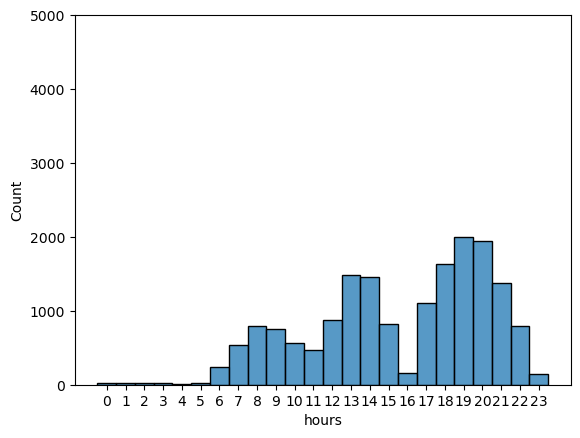

In [7]:
# проверка получившегося распределения часов

time_hours, title = offline_24h_legit_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True)
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0, 5000);

### 2. Круглосуточные оффлайн категории - фрод.
- фрод транзакции в круглосуточных оффлайн категориях

In [8]:
def offline_24h_fraud_time_dist():
    
    # название паттерна. Пригодится если нужно построить график распределения
    title = "Offline. 24h. Fraud"
    
    # равномерная активность с 8 до 23
    day_time =  np.array([np.random.uniform(8, 23.9) for _ in range(500)]).astype(int)
    
    # равномерная сниженная активность с 0 до 8
    night_time = np.array([np.random.uniform(0, 7.9) for _ in range(120)]).astype(int)
    
    # соединяем все созданные массивы в один и делаем серией
    time_hours = pd.Series(np.concatenate((day_time, night_time), axis=0), name="hours")

    return time_hours, title

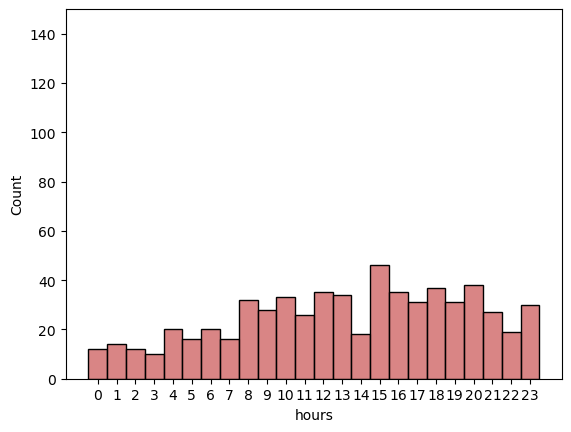

In [10]:
time_hours, title = offline_24h_fraud_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0, 150);

### 3. Онлайн категории, НЕ фрод `online_legit_time_dist`
- Легитимные транзакции. Онлайн покупки. Круглые сутки.
- Равномерно низкая активность ночью и рано утром: с 23:00 до 08:00
- Равномерно низкая активность с 08:00 до 12:00, но чуть выше чем ночью
- небольшой пик в обед: с 12:00 до 16:00
- Пик Вечером после 17:00. между 17 и 22 включительно

In [12]:
def online_legit_time_dist():
    
    # название паттерна. Пригодится если нужно построить график распределения
    title = "Online. Legit"
    
    # Первый слой. равномерно с утра до вечера. с 8:00 до 16:59
    day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(500)]).astype(int)
    
    
    # небольшой пик обед в районе 13. Обрезанный по 12 и 17 часам
    mean_noon = 14 * 60
    std_noon= 75
    noon_start = 12 * 60
    noon_end = 16.5 * 60
    
    # пик обед. Распределение
    dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
    minutes_noon = dist_noon.rvs(400).astype(int)
    
    
    # Вечерний пик. От 17 до 23 часов.
    mean_evn = 19.7 * 60
    std_evn = 120
    evn_start = 17 * 60
    evn_end = 23.3 * 60
    
    # пик вечером. Распределение
    dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
    minutes_evn = dist_evn.rvs(2000).astype(int)
    
    # ночная равномерная низкая активность с 0 до 7:59 утра
    night_hours_add = np.array([np.random.uniform(0, 7.9*60) for _ in range(200)]).astype(int)
    
    # соединяем все созданные массивы в один
    minutes = np.concatenate((day_time, minutes_noon, minutes_evn, night_hours_add), axis=0) #  
    
    times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
    time_hours = times.hours

    return time_hours, title

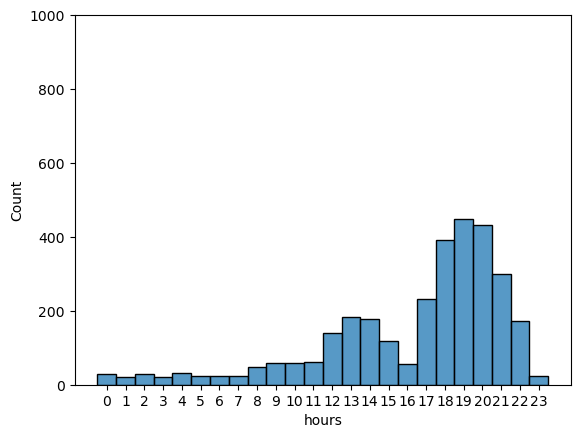

In [13]:
# проверка результата

time_hours, title = online_legit_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True)
p.set_xticks(ticks=time_hours.unique())
p.set_ylim(0, 1000);

### 4. Онлайн фрод
- Равномерно с раннего утра до вечера
- активность вечером-ночью с пиком в районе 00:00

In [14]:
def online_fraud_time_dist():
    # Время в минутах с начала суток. В данном случае нужно для ограничения распределения в рамках 24 часов.
    start, end = 0, 1439  # 00:00 до 23:59

    # название паттерна. Пригодится если нужно построить график распределения
    title = "Online. Fraud"
    
    # Ночной пик после 00:00
    mean = 1 # 1-я минута суток
    std = 120
    
    # распределение ночного пика с максимумом примерно в первом часу суток: 00:00-00:59.
    # Обрезка распределения слева по 00:00
    dist = truncnorm((start - mean) / std, (end - mean) / std, loc=mean, scale=std)
    minutes = dist.rvs(2000).astype(int)
    
    # Добавляем вечернюю активность - обрезка справа в 0 часов. Ограничиваем значения 00:00 часами справа
    mean_evn = 23.9*60
    std_evn = 120
    evn_end = 23.9*60
    
    dist_evn = truncnorm((start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
    minutes_evn = dist_evn.rvs(2000).astype(int)
    
    # добавим небольшое количество равномерных значений на протяжении дня, с 4 до 20 включительно
    mid_start = 4 * 60
    mid_end = 20.9 * 60
    midday_add =  np.array([np.random.uniform(mid_start, mid_end) for _ in range(4250)]).astype(int)
    
    # соединяем все три массива
    total_minutes = np.concatenate((minutes, midday_add, minutes_evn)) # 
    
    times = pd.Series(pd.to_timedelta(total_minutes, unit="min")).dt.components
    time_hours = times.hours

    return time_hours, title

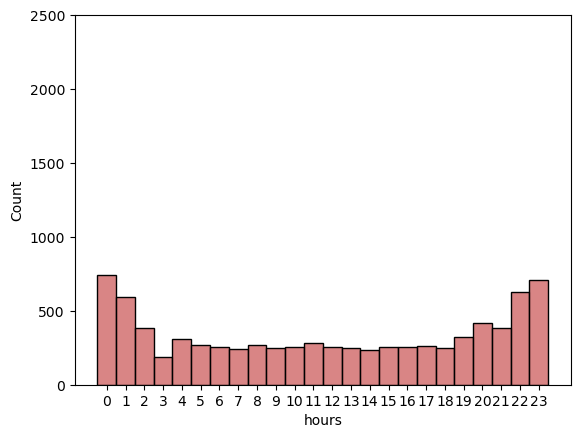

In [15]:
time_hours, title = online_fraud_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0,2500);

### 5. Дневной оффлайн, легитимные транзакции.
- Время с 8:00 до 22:00. С пиками в обед (небольшой) и вечером (основной)

In [16]:
def offline_day_legit_time_dist():

    # название паттерна. Пригодится если нужно построить график распределения
    title = "Offline. Day-only. Legit"
    
    # равномерное распределение с 8:00 до 17:00
    day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(2000)]).astype(int)
    
    # слабый пик обед в районе 13. Интервал с 12 до 17:00
    mean_noon = 14 * 60
    std_noon= 75
    noon_start = 12 * 60
    noon_end = 16.5 * 60
    
    # пик обед
    dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
    minutes_noon = dist_noon.rvs(1000).astype(int)
    
    
    # Вечерний пик. С 17:00 до 22:00
    mean_evn = 19.7 * 60
    std_evn = 120
    evn_start = 17 * 60
    evn_end = 21.9 * 60
    
    # пик вечером
    dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
    minutes_evn = dist_evn.rvs(9000).astype(int)
    
    
    # соединяем все созданные массивы в один
    minutes = np.concatenate((day_time, minutes_noon, minutes_evn), axis=0) #
    
    # переводим значения массива в тип pd.Timedelta.
    # Затем через аттрибут .dt.components получаем датафрейм со значениями массива разбитых на колонки hours и minutes
    # берем hours оттуда
    times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
    time_hours = times.hours

    return time_hours, title

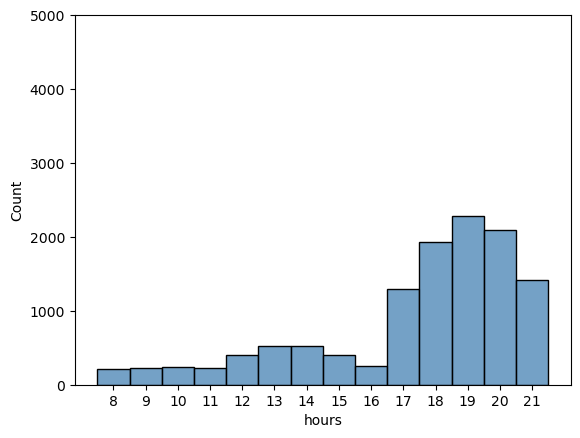

In [17]:
time_hours, title = offline_day_legit_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="steelblue")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0,5000);

### 6. Дневной оффлайн. Фрод
- равномерно с 08:00 до 22:00

In [18]:
def offline_day_fraud_time_dist():
    # название паттерна. Пригодится если нужно построить график распределения
    title = "Offline. Day-only. Fraud"

    # равномерная активность с 8:00 до 22:00
    day_time =  np.array([np.random.uniform(8, 21.9) for _ in range(500)]).astype(int)
    
    # переведем массив в серию
    time_hours = pd.Series(day_time, name="hours")

    return time_hours, title

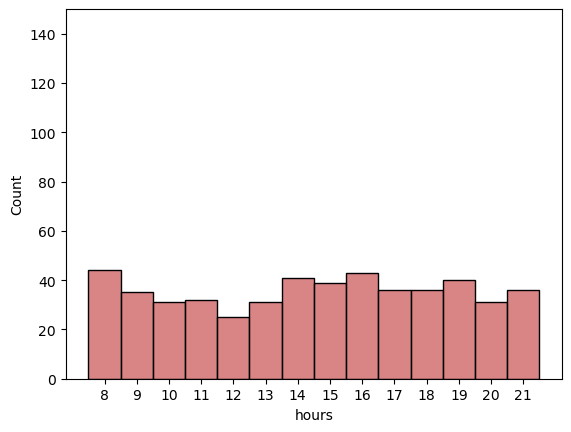

In [19]:
time_hours, title = offline_day_fraud_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0, 150);

# Функция генерации весов для часов в периоде времени `gen_weights_for_time` - Созданная из подфункций <br>
На основании созданный функций распределений времени для соответсвующих временных паттернов, выдает веса(доли) для каждого часа в распределении.
Которые будут в использоваться в рандомизации времени генерируемой транзакции

In [20]:
def gen_weights_for_time(is_fraud=False, round_clock=False, online=False):
    """
    возвращает датафрейм с часами от 0 до 23 и их весами,
    название паттерна в виде строки и цвет для возможного графика - в зависимости от фрод не фрод
    
    is_fraud - True или False. По умолчанию False
    round_clock - Круглосуточная категория или нет. True или False. По умолчанию False
    online - None, True или False. По умолчанию False
    """
    
    #  Далее в зависимости от условий генерация распределения времени для транзакций

    # 1. Категория - круглосуточные, оффлайн, НЕ фрод 
    if not is_fraud and round_clock and not online:
        time_hours, title = offline_24h_legit_time_dist()
        
    # 2. Оффлайн фрод. круглосуточные категории
    elif is_fraud and round_clock and not online:
        time_hours, title = offline_24h_fraud_time_dist()

    # 3. НЕ фрод. Онлайн покупки
    elif not is_fraud and round_clock and online:
        time_hours, title = online_legit_time_dist()
        
    # 4. онлайн фрод
    elif is_fraud and round_clock and online:
        time_hours, title = online_fraud_time_dist()

    # 5. Не круглосуточный. Не фрод. Оффлайн
    elif not is_fraud and not round_clock and not online:
        time_hours, title = offline_day_legit_time_dist()

    # 6. Фрод. Не круглосуточный. Оффлайн. 
    elif is_fraud and not round_clock and not online:
        time_hours, title = offline_day_fraud_time_dist()
        
    
    # посчитаем долю каждого часа. Это и будут веса 
    # т.е. вероятность транзакций в этот час для выбранного временного паттерна
    # переведем индекс в колонку т.к. в индексе у нас часы
    hour_weights = time_hours.value_counts(normalize=True).sort_index().reset_index()

    # если период не круглосуточный. То добавить колонку остальных часов со значениями равными 0, для построения графиков со шкалой от 0 до 23
    if not round_clock:
        all_hours = pd.DataFrame({"hours":np.arange(0,24, step=1)}).astype(int)
        hour_weights = all_hours.merge(hour_weights, how="left", on="hours").fillna(0)
        
    # цвет для графика.
    if not is_fraud:
        color = "steelblue"
    elif is_fraud:
        color = "indianred"
        
    return hour_weights, title, color

## Функция генерации весов для всех паттернов времени и сбора их в словарь
содержит в себе функцию `gen_weights_for_time()`
Нужна для генерации всех паттернов один раз, чтобы дальше не вызывать функцию генерации каждого паттерна каждый раз для транзакции либо по отдельности записывать в переменные

In [21]:
def get_all_time_patterns(pattern_args):
    """
    pattern_args - словарь с названием паттерна в ключе и словарем из аргументов для функции gen_weights_for_time,
                   соответствующим паттерну.
    """

    time_weights = defaultdict(dict)
    
    for key in pattern_args.keys():
        weights, title, color = gen_weights_for_time(**pattern_args[key])
        time_weights[key]["weights"] = weights
        time_weights[key]["title"] = title
        time_weights[key]["color"] = color

    return time_weights

# Тест функции `gen_weights_for_time()`

In [22]:
# hour_weights, _, _ = gen_weights_for_time(is_fraud=True, round_clock=False, online=False)

In [23]:
# маппинг типа распределения и аргументов для функции gen_weights_for_time

time_weight_args = {
                        "Offline_24h_Legit":{"is_fraud":False, "round_clock":True, "online":False},
                        "Offline_24h_Fraud":{"is_fraud":True, "round_clock":True, "online":False},
                        "Online_Legit":{"is_fraud":False, "round_clock":True, "online":True},
                        "Online_Fraud":{"is_fraud":True, "round_clock":True, "online":True},
                        "Offline_Day_Legit":{"is_fraud":False, "round_clock":False, "online":False},
                        "Offline_Day_Fraud":{"is_fraud":True, "round_clock":False, "online":False},
                        }

## Графики каждого из распределений весов времени
запустим функцию и построим график каждого из распределений

In [24]:
# функция построения одиночного графика распределения

def plot_time_weights(weights, title, color, ax):
    sns.barplot(x=weights.hours, y=weights.proportion, color=color, ax=ax)
    ax.set_xlim(-0.5, 23.5)
    ax.set_ylim(0, 0.4)
    ax.grid(axis="y")
    ax.set_title(title)

In [25]:
time_weights_test = get_all_time_patterns(time_weight_args)

In [26]:
# функция построения нескольких графиков time_weights в две колонки

def plot_all_patterns(time_weights):
    """
    Строит графики всех распределений из time_weights
    time_weights - словарь с ключами - названиями паттернов и
                   под каждым ключом еще словарь с весами для паттерна,
                   названием для графика и цветом графика.
                   Его можно сгенерировать функцией get_all_time_patterns
    """
    
    dict_len = len(time_weights)
    rows_number = math.ceil(dict_len / 2)
    
    rows_list = []
    one_row = []
      
    for index, key in enumerate(time_weights.keys(), start=1):
        one_row.append(key)
        if len(one_row) == 2 or index == dict_len:
            rows_list.append(one_row.copy())
            one_row = []
    
    
    fig, axes = plt.subplots(nrows=rows_number, ncols=2, figsize=(10, rows_number*3))
    
    for sub_axes, keys in zip(axes, rows_list):
        for ax, key in zip(sub_axes, keys):
            weights = time_weights[key]["weights"]
            title = time_weights[key]["title"]
            color = time_weights[key]["color"]
            # строим график на его оси
            plot_time_weights(weights, title, color, ax)
    
    plt.tight_layout()
    plt.show()

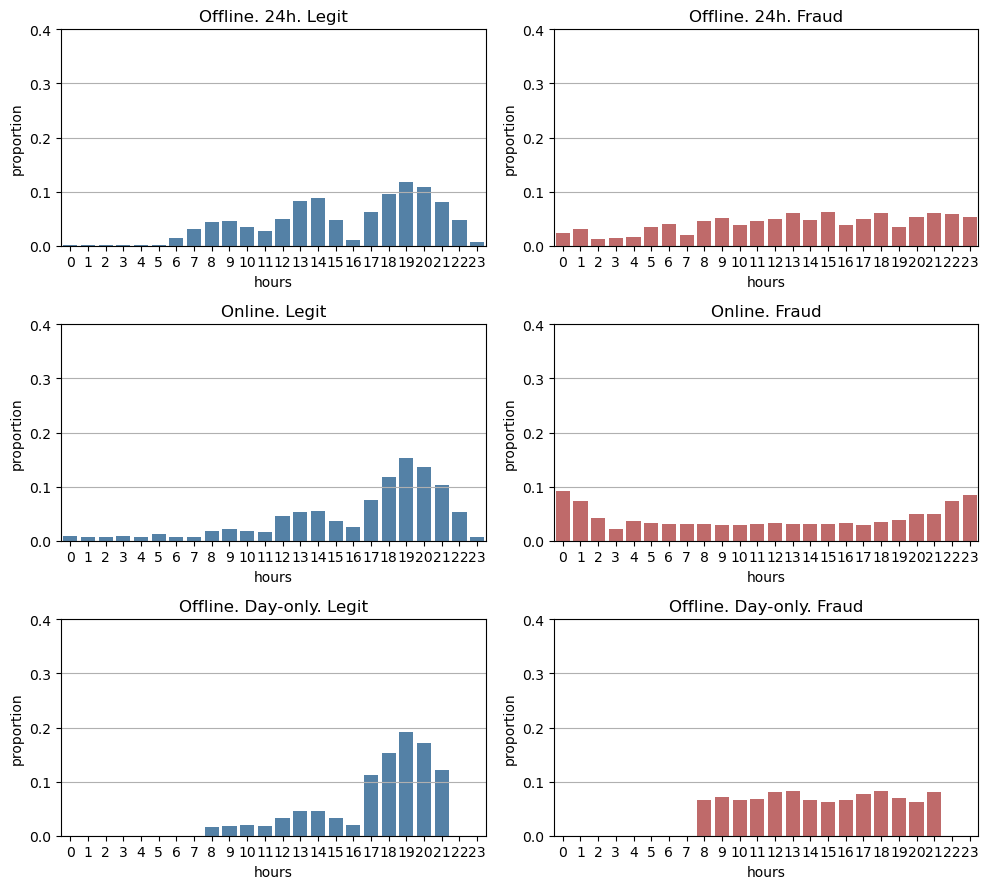

In [27]:
# построим графики для всех распределений

plot_all_patterns(time_weights_test)

In [28]:
# строим графики всех распределений

# fig, axes = plt.subplots(nrows=6, figsize=(7, 6*3))

# for ax, weight_args_key in zip(axes, time_weight_args.keys()):
#     weights, title, color = gen_weights_for_time(**time_weight_args[weight_args_key])
#     plot_time_weights(weights, title, color, ax)

# plt.tight_layout()
# plt.show()

## Проверка функции `gen_weights_for_time` на генерацию пустых значений
Запустим функцию 100 раз для каждого типа распределения и проверим были ли случаи когда для какого-то часа не создался вес.
Будет посчитано количество случаев когда создалось распределение с весами не для всех часов, которые указаны в периоде для распределения

In [29]:
# словарь для подсчета распределений в которых были пустые значения
empt = defaultdict(int)

# итерирование через варианты распределений
for preset in time_weight_args.keys():
    i = 0
    
    round_clock =  time_weight_args[preset]["round_clock"]

    # создать каждое распределение 100 раз
    while i < 100:
        weights, _, _ = gen_weights_for_time(**time_weight_args[preset])
        
        # если круглосуточное распределение и меньше 24 записей
        if round_clock and weights.shape[0] < 24:
            empt[preset] += 1
            
        # если чисто дневное распределение и меньше 14 записей (22 - 8)
        elif not round_clock and weights[weights.proportion != 0].shape[0] < (22 - 8):
            empt[preset] += 1
        

        # if round_clock:
        #     print(f"{preset} - {weights.shape[0]}")
        # elif not round_clock:
        #     print(f"{preset} - {weights[weights.proportion != 0].shape[0]}")

        i += 1

# если словарь не пуст, то ошибка
if empt:
    raise ValueError(f"Some time distributions may generate 0 values. {empt}")
else:
    print("No empty values generated in distributions")

No empty values generated in distributions


# Выбор случайного времени для транзакции
Оно будет основано на созданных ранее весах.
Но нам также понадобятся данные о категориях покупок, тоже нужны веса категорий и их информация: онлайн/оффлайн, круглосуточная/некруглосуточная, вероятность фрода. Далее мы создадим небольшой датафрейм с нужными данными для категории

## Создание признаков для категорий покупок

In [30]:
# category_stats загружен ранее из csv.
# добавим колонку онлайн или не онлайн категория со значениями True и False соответсвенно

category_stats.loc[category_stats.category.str.contains("net"), "online"] = True
category_stats.loc[~category_stats.category.str.contains("net"), "online"] = False
category_stats.head(6)

,category,avg_amt,amt_std,cat_count,online
0,gas_transport,63.577001,15.828399,56370,False
1,grocery_pos,115.885327,51.552330,52553,False
2,home,57.995413,48.085281,52345,False
3,shopping_pos,76.862457,232.484678,49791,False
4,kids_pets,57.506913,48.748482,48692,False
5,shopping_net,83.481653,237.219758,41779,True


In [31]:
# добавим долю категории, ее "вес" среди категорий - для определения распростаненности категории

category_stats["share"] = category_stats.cat_count.div(category_stats.cat_count.sum())
category_stats.head()

,category,avg_amt,amt_std,cat_count,online,share
0,gas_transport,63.577001,15.828399,56370,False,0.101436
1,grocery_pos,115.885327,51.552330,52553,False,0.094568
2,home,57.995413,48.085281,52345,False,0.094193
3,shopping_pos,76.862457,232.484678,49791,False,0.089597
4,kids_pets,57.506913,48.748482,48692,False,0.087620


In [32]:
category_stats_final = category_stats.copy()

In [33]:
# умножим средние суммы транзакций по категориям и стандартное отклонение сумм на 10, для приближенности к ценам в рублях

category_stats_final[["avg_amt","amt_std"]] = category_stats_final[["avg_amt","amt_std"]] * 10
category_stats_final

,category,avg_amt,amt_std,cat_count,online,share
0,gas_transport,635.770012,158.283987,56370,False,0.101436
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568
2,home,579.954129,480.852810,52345,False,0.094193
3,shopping_pos,768.624573,2324.846777,49791,False,0.089597
4,kids_pets,575.069126,487.484822,48692,False,0.087620
5,shopping_net,834.816532,2372.197581,41779,True,0.075180
6,entertainment,639.848399,642.299347,40104,False,0.072166
7,personal_care,482.330206,494.109413,39327,False,0.070768
8,food_dining,507.779383,484.490535,39268,False,0.070662
9,health_fitness,538.674317,479.652511,36674,False,0.065994


In [34]:
# Найдем количество фрода по категориям из датасета kaggle. Для определения вероятности фрода при генерации транзакций

fraud_trans_count_by_cat = fraud_kaggle.query("is_fraud == 1") \
                                        .groupby("category", as_index=False).agg({"trans_num":"count"}) \
                                        .rename(columns={"trans_num":"fraud_count"})
fraud_trans_count_by_cat.head()

,category,fraud_count
0,entertainment,59
1,food_dining,54
2,gas_transport,154
3,grocery_net,41
4,grocery_pos,485


In [35]:
cat_stats_full = category_stats_final.merge(fraud_trans_count_by_cat, on="category")
cat_stats_full.head(3)

,category,avg_amt,amt_std,cat_count,online,share,fraud_count
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568,485
2,home,579.954129,480.852810,52345,False,0.094193,67


In [36]:
# доля фрода в категории

cat_stats_full["fraud_share"] = cat_stats_full.fraud_count.div(cat_stats_full.cat_count)
cat_stats_full.head()

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154,0.002732
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568,485,0.009229
2,home,579.954129,480.852810,52345,False,0.094193,67,0.001280
3,shopping_pos,768.624573,2324.846777,49791,False,0.089597,213,0.004278
4,kids_pets,575.069126,487.484822,48692,False,0.087620,65,0.001335


In [37]:
# Добавим критерий возможности круглосуточной покупки в категории

cat_stats_full["round_clock"] = False

round_clock = ['gas_transport', 'grocery_pos','shopping_net', 'food_dining', 'misc_pos', 'misc_net', 'grocery_net']

for category in round_clock:
    cat_stats_full.loc[cat_stats_full.category == category, "round_clock"] = True
cat_stats_full

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154,0.002732,True
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568,485,0.009229,True
2,home,579.954129,480.852810,52345,False,0.094193,67,0.001280,False
3,shopping_pos,768.624573,2324.846777,49791,False,0.089597,213,0.004278,False
4,kids_pets,575.069126,487.484822,48692,False,0.087620,65,0.001335,False
5,shopping_net,834.816532,2372.197581,41779,True,0.075180,506,0.012111,True
6,entertainment,639.848399,642.299347,40104,False,0.072166,59,0.001471,False
7,personal_care,482.330206,494.109413,39327,False,0.070768,70,0.001780,False
8,food_dining,507.779383,484.490535,39268,False,0.070662,54,0.001375,True
9,health_fitness,538.674317,479.652511,36674,False,0.065994,52,0.001418,False


### Сохранение `cat_stats_full` в csv

In [38]:
cat_stats_full.to_csv("./data/cleaned_data/cat_stats_full.csv")

In [39]:
time_weights = get_all_time_patterns(time_weight_args)

# Разбивка будущей функции генерации времени транзакции `get_time_for_trans` на подфункции
- Не все функции в этом блоке будут частью `get_time_for_trans`. Некоторые будут просто связаны с этой функцией, например, создавать данные для аргументов

## Функции для генерации диапазона timestamp-ов

**Функция перевода pd.Series с datetime64 в unix time в секундах**

In [153]:
def datetime_series_to_unix(series):
    """
    Функция перевода pd.Series с datetime64 в unix time в секундах
    ----------------------
    series - pd.Series с типом datetime64
    """
    unix_time_series = (series - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    return unix_time_series

**Функция создания датафрейма с диапазоном timestamp-ов**

In [154]:
def create_timestamps_range_df(start, end, format="%Y-%m-%d", freq="min"):
    """
    функция создания датафрейма с диапазоном timestamp-ов.
    Возвращает pd.DataFrame | timestamp | hour | unix_time
    -----------------------------------------------------
    start - str. начало диапазона. Дата или дата и время формата указанного в format. По умолчанию %Y-%m-%d
    end - str. конец диапазона. Дата или дата и время формата указанного в format. По умолчанию %Y-%m-%d
    format - str. Строка формата stftime. Формат передаваемых start и end. 
    freq - str. частота генерации timestamp-ов. Минуты, секунды, дни и т.д. 'min', 's', 'D' etc.
    """
    timestamps = pd.DataFrame(pd.Series(pd.date_range(pd.to_datetime(start, format=format), \
                                                  pd.to_datetime(end, format=format), freq=freq), name="timestamp"))
    timestamps["hour"] = timestamps.timestamp.dt.hour
    timestamps["unix_time"] = datetime_series_to_unix(timestamps.timestamp)

    return timestamps

**Функция перевода pd.Timestamp в unix время**

In [40]:
def pd_timestamp_to_unix(timestamp):
    """
    Переводит pandas timestamp в unix время
    timestamp - чистый pandas timestamp. Без индексов. Не серия, не датафрейм.
    """
    unix_time = (timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    return unix_time

**Датафрейм под транзакции. Этап тестов**<br>
Создадим пустой датафрейм под транзакции. Будем копировать и использовать его при тестах функций.

In [339]:
transactions = pd.DataFrame(
            {"client_id": pd.Series(dtype="int64"),
            "txn_time": pd.Series(dtype="datetime64[ns]"),
             "unix_time":pd.Series(dtype="int64"),
            "amount": pd.Series(dtype="float64"),
            "type": pd.Series(dtype="string"),
            "channel": pd.Series(dtype="string"),
            "category": pd.Series(dtype="string"),
            "online":pd.Series(dtype="bool"),
            "merchant_id":pd.Series(dtype="int64"),
             "trans_city":pd.Series(dtype="string"),
            "trans_lat":pd.Series(dtype="float64"),
             "trans_lon":pd.Series(dtype="float64"),
            "trans_ip":pd.Series(dtype="string"),
             "account_to": pd.Series(dtype="int64"),
            "is_fraud": pd.Series(dtype="bool"),
             "is_suspicious": pd.Series(dtype="bool"),
            "status":pd.Series(dtype="string"),
            "rule":pd.Series(dtype="string")})
transactions

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule


## Подфункция для генерации времени когда нет предыдущих транзакций `sample_time_for_trans`

In [41]:
def sample_time_for_trans(timestamps, time_weights):
    """
    Для понимания аргументов см. docstring для get_time_for_trans.
    Для этого исполни ?get_time_for_trans в ячейке

    Генерирует время для транзакции в виде timestamp и unix времени
    """
    # семплируем час из весов времени, указав веса для семплирования
    txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
    
    # фильтруем основной датафрейм с диапазоном таймстемпов по этому часу
    timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
    
    # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
    txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
    txn_unix = pd_timestamp_to_unix(txn_time)

    return txn_time, txn_unix

# Подфункция `check_min_interval_from_near_trans` - когда есть предыдущие транзакции

In [573]:
def check_min_interval_from_near_trans(client_txns, timestamp_sample, online, round_clock, offline_time_diff=60, \
                                       online_time_diff=6, online_ceil=60, general_diff=30, general_ceil=90):
    """
    Если для сгенерированного времени есть транзакции, которые по времени ближе заданного минимума, 
    то создать время на основании времени последней транзакции + установленный минимальный интервал.
    Учитывает разницу между типами транзакций: онлайн-онлайн, онлайн-оффлайн, оффлайн-оффлайн.
    Можно поставить свои минимальные интервалы для случаев: онлайн-онлайн, онлайн-оффлайн, оффлайн-оффлайн. 
    Для оффлайн-оффлайн - один фиксированный интервал.
    Для онлайн-онлайн задается минимум и максимум откуда интервал берется с равной вероятностью
    Для оффлайн-онлайн задается минимум и максимум откуда интервал берется с равной вероятностью
    -----------------------------------------------

    client_txns - датафрейм с транзакциями клиента.
    timestamp_sample - случайно выбранная запись из датафрейма с таймстемпами
    online - boolean. Онлайн или оффлайн категория
    round_clock - boolean. Круглосуточная или дневная категория.
    offline_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
    online_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
    online_ceil - int. желаемая максимальная разница от последней оффлайн транзакции в минутах
    general_diff - int. минимально допустимая разница от последней транзакции противоположной по флагу online.
    general_ceil - int. максимальная разница от последней транзакции противоположной по флагу online.
                   При случае необходимости увеличения разрыва времени.
    ------------------------------------------------
    Возвращает pd.Timestamp и int unix время в секундах 
    """

    # перевод аргументов в секунды для работы с unix time
    offline_time_diff= offline_time_diff * 60
    online_time_diff= online_time_diff * 60
    online_ceil= online_ceil * 60
    general_diff = general_diff * 60
    general_ceil = general_ceil * 60

    
    timestamp_unix = timestamp_sample.unix_time.iloc[0]
    # Копия, чтобы не внести изменения в исходный датафрейм
    client_txns = client_txns.copy()
    client_txns["abs_time_proximity"] = client_txns.unix_time.sub(timestamp_unix).abs()

    # Запись о ближайшей по времени транзакции
    closest_txn = client_txns.loc[client_txns.abs_time_proximity == client_txns.abs_time_proximity.min()]
    # Онлайн или не онлайн ближайшая по времени транзакция
    closest_online_flag = closest_txn.online.iloc[0]
    # Разница семплированного timestamp-а с ближайшей по времени транзакцией
    closest_time_diff = closest_txn.abs_time_proximity.iloc[0]

    # Запись о последней транзакции
    last_txn = client_txns.loc[client_txns.unix_time == client_txns.unix_time.max()]
    # Онлайн или не онлайн последняя транзакция
    last_online_flag = last_txn.online.iloc[0]
    # unix время
    last_txn_unix = last_txn.unix_time.iloc[0]
    
    # Если, создаваемая транзакция оффлайн и ближайшая по времени тоже оффлайн
    # И разница меньше допустимой
    if not online and not closest_online_flag and closest_time_diff < offline_time_diff:
        close_flag = "offline_to_offline"

    # Если оффлайн транзакция и ближайшая онлайн. И разница меньше допустимой
    elif not online and closest_online_flag and closest_time_diff < general_diff:
        close_flag = "offline_to_online"
        
    # Если, создаваемая транзакция онлайн и ближайшая по времени тоже онлайн
    # И разница меньше допустимой
    elif online and closest_online_flag and closest_time_diff < online_time_diff:
        close_flag = "online_to_online"

    # Если онлайн транзакция и ближайшая оффлайн. И разница меньше допустимой
    elif online and not closest_online_flag and closest_time_diff < general_diff:
        close_flag = "online_to_offline"
        
    # Если нет транзакций ближе установленной разницы
    # Просто берем изначальный timestamp
    else:
        close_flag = False
        txn_unix = timestamp_unix
        txn_time = pd.to_datetime(txn_unix, unit="s")

    # Если транзакция близка по времени к другой, то согласно типам транзакций
    # создаем другое время на основании времени и типа последней и текущей транзакции
    if close_flag in ["offline_to_offline", "offline_to_online"]:
        # Если последняя транзакция Онлайн. То добавляем случайную разницу для онлайн и оффлайн транзакций в установленном диапазоне
        if last_online_flag:
            general_random_diff = random.randint(general_diff, general_ceil)
            txn_unix = last_txn_unix + general_random_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")
            
        # Если последняя транзакция Оффлайн. То добавляем допустимую разницу между оффлайн транзакциями
        elif not last_online_flag:
            txn_unix = last_txn_unix + offline_time_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")

    # Если текущая транзакция онлайн и есть онлайн/оффлайн транзакция с разницей меньше допустимой
    elif close_flag in ["online_to_online", "online_to_offline"]:
        # Если последняя транзакция онлайн. То добавляем случайную разницу для онлайн транзакций в установленном диапазоне
        if last_online_flag:
            online_random_diff = random.randint(online_time_diff, online_ceil)
            txn_unix = last_txn_unix + online_random_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")
            
        # Если последняя транзакция Оффлайн. То добавляем случайную разницу для онлайн и оффлайн транзакций в установленном диапазоне
        elif not last_online_flag:
            general_random_diff = random.randint(general_diff, general_ceil)
            txn_unix = last_txn_unix + general_random_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")

    # Проверка и корректировка времени, на случай если категория дневная, и время выходит за рамки этой категории
    # Если час меньше 8 или больше 21. Т.е. ограничение 08:00-21:59
    if not round_clock and txn_time.hour < 8 or txn_time.hour > 21:
        txn_time = txn_time + pd.Timedelta(10, unit="h")
        txn_unix = pd_timestamp_to_unix(txn_time)
  
    return txn_time, txn_unix

**Тест функции `check_min_interval_from_near_trans`**

**Тест-кейсы**

- Текущая оффлайн, ближайшая ближе допустимого
    - ближайшая оффлайн, последняя онлайн
    - ближайшая оффлайн, последняя оффлайн
    - ближайшая онлайн, последняя оффлайн
    - ближайшая онлайн, последняя онлайн
- Текущая онлайн, ближайшая ближе допустимого
    - ближайшая оффлайн, последняя онлайн
    - ближайшая оффлайн, последняя оффлайн
    - ближайшая онлайн, последняя оффлайн
    - ближайшая онлайн, последняя онлайн
- разница допустима
    - ближайшая оффлайн
    - ближайшая онлайн

In [90]:
other_time = pd.to_datetime("2023-09-20 10:00:00", format="%Y-%m-%d %H:%M:%S")
other_unix = pd_timestamp_to_unix(other_time)
other_time, other_unix

(Timestamp('2023-09-20 10:00:00'), 1695204000)

**nearest txn time**

In [134]:
nearest_time = pd.to_datetime("2023-09-20 08:59:00", format="%Y-%m-%d %H:%M:%S")
nearest_unix = pd_timestamp_to_unix(nearest_time)
nearest_time, nearest_unix

(Timestamp('2023-09-20 08:59:00'), 1695200340)

**last txn time**

In [575]:
last_time = pd.to_datetime("2023-09-21 04:59:00", format="%Y-%m-%d %H:%M:%S")
last_unix = pd_timestamp_to_unix(last_time)
last_time, last_unix

(Timestamp('2023-09-21 04:59:00'), 1695272340)

**current txn time**

In [567]:
timstamp_check_min = pd.to_datetime("2023-09-20 09:15:00", format="%Y-%m-%d %H:%M:%S")
timstamp_check_min_unix = pd_timestamp_to_unix(timstamp_check_min)
timestamp_sample_check_min = pd.DataFrame([{"timestamp":timstamp_check_min, "unix_time":timstamp_check_min_unix}])
timestamp_sample_check_min

,timestamp,unix_time
0,2023-09-20 09:15:00,1695201300


**txns dataframe**

In [576]:
trans_time_test = transactions.copy().loc[:, ['txn_time', 'unix_time','online','account_to', \
                                                                  'is_fraud', 'is_suspicious']]

**previous txns times and online flag**

In [577]:
# Выставить online флаги для nearest и last в соответсвии с тест-кейсом. Other можно пренебречь

# trans_time_test.loc[0, ["txn_time","unix_time", "online"]] = other_time, other_unix, False
trans_time_test.loc[1, ["txn_time","unix_time", "online"]] = nearest_time, nearest_unix, True
trans_time_test.loc[2, ["txn_time","unix_time", "online"]] = last_time, last_unix, True
trans_time_test

,txn_time,unix_time,online,account_to,is_fraud,is_suspicious
1,2023-09-20 08:59:00,1.695200e+09,True,NaN,NaN,NaN
2,2023-09-21 04:59:00,1.695272e+09,True,NaN,NaN,NaN


**Запуск функции**

In [578]:
# Выставить в функции аргумент online в соответсвии с тест-кейсом
# True - создаваемая транзакция - онлайн. False - оффлайн
txn_time, txn_unix = check_min_interval_from_near_trans(client_txns=trans_time_test, timestamp_sample=timestamp_sample_check_min, online=False, \
                                                        round_clock=False, offline_time_diff=60, online_time_diff=6, online_ceil=60, \
                                                        general_diff=30, general_ceil=90)

# Запись сгенерированной транзакции в датафрейм: время, online флаг
trans_time_test.loc[3, ["txn_time","unix_time", "online"]] = txn_time, txn_unix, False
trans_time_test = trans_time_test.sort_values("txn_time")

# Расчет времени между транзакциями в минутах
trans_time_test["abs_time_proximity"] = trans_time_test.unix_time.sub(trans_time_test.unix_time.shift(1)).div(60)
trans_time_test

,txn_time,unix_time,online,account_to,is_fraud,is_suspicious,abs_time_proximity
1,2023-09-20 08:59:00,1.695200e+09,True,NaN,NaN,NaN,NaN
2,2023-09-21 04:59:00,1.695272e+09,True,NaN,NaN,NaN,1200.000000
3,2023-09-21 15:34:35,1.695310e+09,False,NaN,NaN,NaN,635.583333


## Подфункция генерации времени для фрод кейсов `fast_geo_change` и `fast_geo_change_online`

In [579]:
def generate_time_fast_geo_jump(last_txn_unix, geo_distance, threshold=800):
        """
        Генерация времени с коротким интервалом от предыдущей транзакции, для имитации быстрой смены геопозиции
        ---------------------------------------------------------------------
        last_txn_unix - время последней транзакции в unix формате в секундах.
        geo_distance - кратчайшая дистанция между точками координат последней и текущей транзакции - в километрах.
                       Точки между координатами берутся при генерации транзакции. Домашний город клиента и любой другой город, кроме домашнего.
        threshold - порог скорости перемещения между точками в км/ч. Все что быстрее - фрод.
                    Это нужно чтобы генерировать соответствующее время в зависимости от дистанции между точками транзакций.
                    Быстрая скорость - маленькое время между транзакциями в плане возможностей перемещения на расстояние.
        ---------------------------------------------------------------------
        Возвращает pd.Timestamp и unix время в секундах.
        """

        # Случайно сгенерированная фактическая скорость превышающая легитимный порог. Допустим от 801 до 36000 км/ч
        # до 36000 км/ч т.к. грубо говоря транзакция может быть совершена через 20 минут в 9000 км от предыдущей т.е. как-будто бы скорость 36000 км/ч
        # 9000 км взяты как весьма примерное, самое длинное возможное расстояние между городами России при путешествии самолетом.
        # но в зависимости от расстояния мы берем разные границы для распределений, чтобы не было перекоса в очень быстрое время. 
        # Также 20 минут я случайно взял как средний интервал для подобной фрод транзакции.
        # Конечно же "скорость перемещения" может быть и больше в реальной жизни
        
        if geo_distance < 1000:
            fact_speed = np.random.uniform(threshold + 1, 3000)
        elif geo_distance >= 1000 and geo_distance <= 3000:
            fact_speed = np.random.uniform(threshold + 1, 9000)
        elif geo_distance > 3000 and geo_distance <= 6000:
            fact_speed = np.random.uniform(threshold + 1, 18000)
        else:
            fact_speed = np.random.uniform(threshold + 1, 36000)
        
        # Делим полученную скорость на 3.6 для перевода в м/с - для расчета времени в секундах
        # т.к. будет добавлять к unix времени предыдущей транзакции
        fact_speed /= 3.6

        # переводим дистанцию в метры
        geo_distance = geo_distance * 1000
    
        # интервал времени между последней транзакцией и текущей фрод транзакцией в секундах
        time_interval = geo_distance / fact_speed
        
        txn_unix = round(last_txn_unix + time_interval)
        txn_time = pd.to_datetime(txn_unix, unit="s")

        return txn_time, txn_unix

In [143]:
# Тест generate_time_fast_geo_jump()

# distances = pd.DataFrame({"distance":[800]*10 + [1200]*10 + [5000]*10 + [7500]*10})
# distances["minutes"] = 0

# for row in distances.itertuples():
#     minutes, _, _ = generate_time_fast_geo_jump(last_txn_unix=last_unix, geo_distance=row.distance, threshold=800)
#     distances.loc[row.Index, "minutes"] = minutes

# distances.groupby("distance").minutes.mean()

In [144]:
# for dist in list(np.arange(0, 9000, 0.1)):
#     generate_time_fast_geo_jump(last_txn_unix=last_unix, geo_distance=dist, threshold=800)


## Подфункция генерации времени транзакции для правила `trans_freq_increase`
- несколько частых транзакций подряд

In [177]:
def gen_time_for_frequent_trans(last_txn_time, last_txn_unix, timestamps, time_weights, lag, lag_interval=30, \
                                freq_low=1, freq_high=5, test=False, test_timestamp=None):
    """
    Функция для имитации времени нескольких частых транзакций подряд.
    -------------------------------------------------
    last_txn_time - pd.Timestamp последней транзакции
    last_txn_unix - unix время последней транзакции в секундах
    timestamps - pd.DataFrame с диапазоном pd.Timestamp-ов и их unix аналогом в секундах и колонкой часа timestamp-а
    lag - True или False. Является ли текущая транзакция первой в серии мошеннических/подозрительных учащенных транзакций.
          При True будет добавлен лаг равный lag_interval от предыдущей легальной транзакции
    lag_interval - int. лаг от предыдущей транзакции в минутах
    freq_low - int. минимальный разрыв между транзакциями в цепочке фрод транзакций, в минутах
    freq_high - int. максимальный разрыв между транзакциями в цепочке фрод транзакций, в минутах
    test - True или False. Тестируем мы функцию или нет. Если тестируем, то надо передать test_timestamp
    test_timestamp - str. Дата и время в формате '1899-01-01 00:00:00'. Это замена семплируемуго внутри
                     функции timestamp-а, который проверяется на разницу во времени с последней легальной транзакцией.
    --------------------------------------------------
    При test == False возвращает pd.Timestamp и unix time в секундах
    При test == True возвращает pd.Timestamp, unix time в секундах и получившуюся разницу времени с предыдущей транзакцией в минутах в виде int
    """

    # перевод минут в секунды для удобства подсчета с unix time
    lag_interval = lag_interval * 60
    
    # если транзакция первая в серии фрод транзакций - аргумент lag равен True. И не режим тестирования функции
    if lag and not test:
        
        # Фильтруем timestamp-ы, оставляя те, что после последней легитимной транзакции
        timestamp_after_last_trans = timestamps.loc[timestamps.timestamp > last_txn_time]

        # Семплируем час первой транзакции, передав веса часов.
        # Затем фильтруем timestamp-ы по этому часу
        txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
        timestamps_subset = timestamp_after_last_trans.loc[timestamp_after_last_trans.hour == txn_hour]
        # семплируем таймстемп из таймстемпов по времени не ранее последней транзакции
        timestamp_sample = timestamps_subset.sample(n=1, replace=True)
        # Узнаем разницу между timestamp-ом и последней транзакцией
        trans_time_diff = timestamp_sample.unix_time.sub(last_txn_unix).iloc[0]

    # Если режим тестирования. То timestamp_sample у нас это не семпл, а переданный в аргументе timestamp
    elif lag and test:
        timestamp_sample = pd.DataFrame({"timestamp":pd.Series(dtype="datetime64[s]"), "unix_time":pd.Series(dtype="int64")})
        timestamp_sample.loc[0, "timestamp"] = pd.to_datetime(test_timestamp, format="%Y-%m-%d %H:%M:%S")
        timestamp_sample.loc[0, "unix_time"] = pd_timestamp_to_unix(timestamp_sample.timestamp.iloc[0])
        # Узнаем разницу между timestamp-ом и последней транзакцией
        trans_time_diff = timestamp_sample.unix_time.iloc[0] - last_txn_unix


    # если транзакция первая в серии фрод транзакций
    # и интервал между последней транзакцией менее 30 минут
    # прибавить интервал 30 минут к семплированному времени текущей транзакции
    if lag and trans_time_diff < lag_interval:
        # print("Condition #1")
        time_addition = lag_interval - trans_time_diff
        txn_unix = timestamp_sample.unix_time.iloc[0] + time_addition
        txn_time = pd.to_datetime(txn_unix, unit="s")

    # Если lag равен True, но не надо добавлять интервал
    elif lag:
        # print("Condition #2")
        txn_unix = timestamp_sample.unix_time.iloc[0]
        txn_time = pd.to_datetime(txn_unix, unit="s")

    # для остальных случаев - когда это не первые фрод транзакции в серии
    # просто добавляем 1-5 минут ко времени предыдущей транзакции
    else:
        # частота фрод транзакций. от 1 до 5 минут. Выразим в секундах для удобства расчетов
        freq = random.randint(freq_low, freq_high) * 60
        txn_unix = last_txn_unix + freq
        txn_time = pd.to_datetime(txn_unix, unit="s")

    if not test:
        return txn_time, txn_unix
    
    elif test and lag:
        return txn_time, txn_unix
        
    elif test and not lag:
        return txn_time, txn_unix, freq

**Тест `gen_time_for_frequent_trans` в цикле**

In [146]:
weights_for_freq_trans = time_weights["Online_Fraud"]["weights"]

In [171]:
# Диапазон timestamp-ов для семплирования

timestamps_freq_test = create_timestamps_range_df(start="2023-09-20", end="2023-09-21")

In [175]:
# Датафрейм с последней транзакцией - перезапустить ячейку для теста ниже

last_time = pd.to_datetime("2023-09-20 09:14:00", format="%Y-%m-%d %H:%M:%S")
last_unix = pd_timestamp_to_unix(last_time)

# условно основной датафрейм с транзакциями. У нас там одна легальная последняя транзакция на данный момент

trans_test_freq_time = transactions.copy().loc[:, ['txn_time', 'unix_time','online','account_to', 'is_fraud', 'is_suspicious']]
trans_test_freq_time.loc[0, ["txn_time","unix_time"]] = last_time, last_unix
print(f"last_time, last_unix: {last_time, last_unix}")
trans_test_freq_time

last_time, last_unix: (Timestamp('2023-09-20 09:14:00'), 1695201240)


,txn_time,unix_time,online,account_to,is_fraud,is_suspicious
0,2023-09-20 09:14:00,1.695201e+09,NaN,NaN,NaN,NaN


In [176]:
# в этом скрипте нужно проверить с условиями:
# 1. test_timestamp равен txn_time в исходном датафрейме с последней легальной транзакцией
# 2. test_timestamp больше txn_time в исходном датафрейме с последней легальной транзакцией,на не более чем на 29 минут
# 3. test_timestamp больше txn_time в исходном датафрейме с последней легальной транзакцией, на 30 и более минут

trans_freq_temp_df = transactions.copy().loc[:, ['txn_time', 'unix_time','online','account_to', 'is_fraud', 'is_suspicious']]
last_time = trans_test_freq_time.txn_time.max()
last_unix = trans_test_freq_time.unix_time.max()

test_mode = 3

if test_mode == 1:
    test_timestamp = last_time
elif test_mode == 2:
    test_timestamp = last_time + pd.Timedelta(7, unit="m")
elif test_mode == 3:
    test_timestamp = last_time + pd.Timedelta(30, unit="m")


freq_values = []


for i in range(1,6):
    if i == 1:
        lag = True

        txn_time, txn_unix = gen_time_for_frequent_trans(last_txn_time=last_time, last_txn_unix=last_unix, timestamps=timestamps_freq_test, \
                                                         time_weights=weights_for_freq_trans, lag=lag, \
                                                         test=True, test_timestamp=test_timestamp)
        
    else:
        lag = False
    
        txn_time, txn_unix, freq = gen_time_for_frequent_trans(last_txn_time=last_time, last_txn_unix=last_unix, timestamps=timestamps_freq_test, \
                                                         time_weights=weights_for_freq_trans, lag=lag, \
                                                         test=True, test_timestamp=test_timestamp)
        freq_values.append(freq / 60)
        
    trans_freq_temp_df.loc[i, "txn_time"] = txn_time
    trans_freq_temp_df.loc[i, "unix_time"] = txn_unix
    trans_freq_temp_df.loc[i, "is_fraud"] = True

    
    last_time = txn_time
    last_unix = txn_unix

# средняя частота фрод транзакций - всех, кроме первой фрод транзакции
print("\n\n Mean freq: ",pd.Series(freq_values).mean(), " minutes\n\n")

# к последней легальной транзакции присоединяем сгенерированные частые транзакции
trans_test_freq_time = pd.concat([trans_test_freq_time, trans_freq_temp_df])
# разница во времени с предыдущей транзакцией, в минутах
trans_test_freq_time["time_diff"] = trans_test_freq_time.unix_time.sub(trans_test_freq_time.unix_time.shift(1)) / 60
trans_test_freq_time



 Mean freq:  4.0  minutes




,txn_time,unix_time,online,account_to,is_fraud,is_suspicious,time_diff
0,2023-09-20 09:14:00,1.695201e+09,NaN,NaN,NaN,NaN,NaN
1,2023-09-20 09:44:00,1.695203e+09,NaN,NaN,True,NaN,30.0
2,2023-09-20 09:47:00,1.695203e+09,NaN,NaN,True,NaN,3.0
3,2023-09-20 09:51:00,1.695203e+09,NaN,NaN,True,NaN,4.0
4,2023-09-20 09:56:00,1.695204e+09,NaN,NaN,True,NaN,5.0
5,2023-09-20 10:00:00,1.695204e+09,NaN,NaN,True,NaN,4.0


In [ ]:
# вторая запись. Первая фрод транзакция. time_diff должен быть не менее установленного lag_interval
# trans_test_freq_time.loc[1, "time_diff"]

In [ ]:
# записи с третьей по последнюю - 2-я фрод транзакция и далее. time_diff должно быть в пределах диапазона freq
# trans_test_freq_time.loc[2:(trans_test_freq_time.shape[0] - 1)]

In [ ]:
# txn_hour = time_weights["Offline_24h_Legit"]["weights"].hours.sample(n=1, \
#                                 weights=time_weights["Offline_24h_Legit"]["weights"].proportion, replace=True).iloc[0]
# timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
# timestamp_sample = timestamps_subset.sample(n=1, replace=True)

In [ ]:
# last_time = pd.to_datetime("2024-07-24 19:26:00", format="%Y-%m-%d %H:%M:%S")
# last_unix = pd_timestamp_to_unix(last_time)
# last_time, last_unix

In [ ]:
# timestamp_sample

# Разбитая на подфункции функция `get_time_for_trans` - `Рефакторинг 2.0`<br>
Разбивка на `handle_legit_case` и `handle_fraud_case` функции

## Подфункция для работы с временем для легальных транзакций

In [580]:
def handle_legit_case_time(client_txns, timestamp_sample, online, round_clock):
    """
    Проверяет время для легальной транзакции если есть предыдущие транзакции.
    Обеспечивает минимальный интервал от предыдущих транзакций
    --------------------------------------------------
    client_txns - pd.DataFrame. Предыдущие транзакции клиента.
    timestamp_sample - pd.DataFrame. Семплированный timestamp. | timestamp | unix_time | hour |
    online - boolean. Онлайн или оффлайн транзакция
    round_clock - boolean. Круглосуточная или дневная категория.
    --------------------------------------------------
    Возвращает pd.Timestamp и unix время в секундах в виде int 
    """
    
    # Если текущая транзакция - оффлайн.
    if not online:

        # check_min_interval_from_near_trans проверит ближайшие к timestamp_sample по времени транзакции в соответсвии с установленными
        # интервалами и если время до ближайшей транзакции меньше допустимогшо,то создаст другой timestamp
        # Если интервал допустимый, то вернет исходный timestamp
        
        txn_time, txn_unix = check_min_interval_from_near_trans(client_txns=client_txns, timestamp_sample=timestamp_sample, online=online, \
                                                                round_clock=round_clock, offline_time_diff=60,  online_time_diff=6, online_ceil=60, \
                                                                general_diff=30, general_ceil=90)
        return txn_time, txn_unix

    # То же самое, но если текущая транзакция - онлайн
    elif online:

        txn_time, txn_unix = check_min_interval_from_near_trans(client_txns=client_txns, timestamp_sample=timestamp_sample, online=online, \
                                                                round_clock=round_clock, offline_time_diff=60,  online_time_diff=6, online_ceil=60, \
                                                                general_diff=30, general_ceil=90)
        return txn_time, txn_unix

## Подфункция для работы с временем для фрод транзакций

In [188]:
def handle_fraud_case_time(last_txn_time, last_txn_unix, rule, timestamps, time_weights, geo_distance):
    """
    Генерирует время, чтобы транзакция попала под антифрод-правило
    --------------------------------------------------------------
    last_txn_time - pd.Timestamp. Время последней транзакции
    last_txn_unix - int. Unix время последней транзакции в секундах
    rule - str. Название антифрод-правила.
    time_weights - pd.DataFrame. Вероятностные веса для паттерна времени.
    geo_distance - int. Кратчайшее расстояние между
    --------------------------------------------------------------
    Возвращает pd.Timestamp и int unix время в секундах
    """
    
    # Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
    if rule in ["fast_geo_change", "fast_geo_change_online"]:
        return generate_time_fast_geo_jump(last_txn_unix, geo_distance, threshold=800)

    
    # Увеличение количества транзакций в единицу времени выше установленного порога в процентах.
    elif rule == "trans_freq_increase":
        return gen_time_for_frequent_trans(last_txn_time, last_txn_unix, timestamps, time_weights, lag, \
                                                         lag_interval=30, freq_low=1, freq_high=5)

# Функция `get_time_for_trans` - `рефактор 2.0`

In [581]:
def get_time_for_trans(trans_df, is_fraud, time_weights, timestamps, timestamps_1st_month, \
                       round_clock, online=None, rule=None, geo_distance=None, lag=None):
    """
    trans_df - датафрейм с транзакциями текущего клиента. Откуда брать информацию по предыдущим транзакциям клиента
    is_fraud - boolean. Фрод или не фрод
    time_weights - датафрейм с весами часов в периоде времени
    timestamps - датафрейм с timestamps
    timestamps_1st_month - сабсет timestamps отфильтрованный по первому месяцу и, если применимо, году. Чтобы генерировать первые транзакции
    round_clock - boolean. Круглосуточная или дневная категория.
    online - boolean. Онлайн или оффлайн покупка. True or False
    rule - str. Название антифрод правила
    geo_distance - int. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в километрах
    lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
          Это задержка именно между последней легитимной транзакцией и серией частых фрод транзакций. Подразумевается что функция
          get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.

    Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
    """
    
    # Время последней транзакции клиента. pd.Timestamp и unix в секундах
    last_txn_time = trans_df.txn_time.max()
    last_txn_unix = trans_df.unix_time.max()
    

    # Если нет никакой предыдущей транзакции т.е. нет последнего времени совсем
    # Подразумевается, что первая транзакция будет легальной.
    if not is_fraud and last_txn_time is pd.NaT:

        # время транзакции в виде timestamp и unix time.
        return sample_time_for_trans(timestamps=timestamps_1st_month, time_weights=time_weights)

    
    # Если есть предыдущая транзакция

    # берем случайный час передав веса часов для соответсвующейго временного паттерна
    txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
    
    # фильтруем по этому часу timestamp-ы и семплируем timestamp уже с равной вероятностью
    # Дальше будем обрабатывать этот timestamp в некоторых случаях
    timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
    timestamp_sample = timestamps_subset.sample(n=1, replace=True)

    # ЛЕГАЛЬНЫЕ ТРАНЗАКЦИИ. Если есть предыдущие транзакции
    
    if not is_fraud:
        # Время транзакции в виде pd.Timestamp и unix времени в секундах
        return handle_legit_case_time(client_txns=trans_df, timestamp_sample=timestamp_sample, online=online, round_clock=round_clock)

    
    # ФРОД ТРАНЗАКЦИИ 

    # Список правил, требующих специальной обработки времени
    special_time_rules = ["fast_geo_change", "fast_geo_change_online", "trans_freq_increase"]

    # Фрод в рамкам спец правил
    if is_fraud and rule in special_time_rules:
        return handle_fraud_case_time(last_txn_time, last_txn_unix, rule, timestamps, time_weights, geo_distance)

    # Фрод для других правил.
    # Просто возвращаем семплированный timestamp и его unix вариант
    elif is_fraud:
        txn_time = timestamp_sample.timestamp.iloc[0]
        return txn_time, pd_timestamp_to_unix(txn_time)

# Доп. данные для генерации транзакций

**Загрузка данных:**
- оффлайн мерчантов
- городов с полигонами
- городов с координатами центров
- клиентов с гео и т.д.
- фрод IP адресов

In [193]:
offline_merchants = gpd.read_file("./data/cleaned_data/offline_merchants_points.gpkg")
districts_ru = gpd.read_file("./data/cleaned_data/district_ru.gpkg")
area_centers = gpd.read_file("./data/cleaned_data/area_centers.gpkg")
clients_with_geo = gpd.read_file("./data/cleaned_data/clients_with_geo.gpkg") 
fraud_ips = gpd.read_file("./data/cleaned_data/fraud_ips.gpkg")

## Сгенерируем id для онлайн мерчантов.
Просто, чтобы было чем заполнить поле merchant_id для онлайн покупок

In [194]:
offline_merch_max_id = int(offline_merchants.merchant_id.max())
online_merchant_ids = pd.Series([i for i in range(offline_merch_max_id + 1, offline_merch_max_id + 201)])
online_merchant_ids

0      6777
1      6778
2      6779
3      6780
4      6781
       ... 
195    6972
196    6973
197    6974
198    6975
199    6976
Length: 200, dtype: int64

# Генерация device-ов
Для клиентов и для потенциальных мошенников

## Девайсы клиентов

In [195]:
# проценты использования платформ с мая 2024 по май 2025 по данным https://gs.statcounter.com/os-market-share
# Сделаем это весами, для случайного назначения клиентам их платформ(ы)

platforms_mobile= pd.DataFrame({"platform":["Android", "iOS"], \
                              "weight":[16, 3], "type":["mobile","mobile"]})
platforms_mobile["weight"] = platforms_mobile.weight.div(platforms_mobile.weight.sum())
platforms_mobile

,platform,weight,type
0,Android,0.842105,mobile
1,iOS,0.157895,mobile


In [196]:
platforms_desktop= pd.DataFrame({"platform":["Windows", "macOS", "Linux"], \
                              "weight":[26, 8, 4], "type":["desktop","desktop","desktop"]})
platforms_desktop["weight"] = platforms_desktop.weight.div(platforms_desktop.weight.sum())
platforms_desktop

,platform,weight,type
0,Windows,0.684211,desktop
1,macOS,0.210526,desktop
2,Linux,0.105263,desktop


In [197]:
client_devices = clients_with_geo[["client_id"]].copy()

In [198]:
client_devices["platform"] = "temp_value"
client_devices["device_id"] = 0

In [199]:
# добавим еще по записи на каждого клиента. Т.к. максимальное количество девайсов - 2.
# Потом просто у кого не будет второго девайса, те записи будут удалены

client_devices = pd.concat([client_devices, client_devices], ignore_index=True)

In [200]:
client_devices.shape

(10738, 3)

In [201]:
# назначение платформ клиентам. 
# Клиент может иметь 1 или 2 платформы: мобильную и ПК или какую-то одну из них. 
# Это, конечно же упрощение. Но для демонтсрации антифрод-правил связанных с девайсами, думаю достаточно.


# id для девайса. Это будет своего рода уникальность этого девайса среди других, своего рода фингерпринт.
device_id = 1

for _, row in clients_with_geo.iterrows():
    client_id = row["client_id"]
    
    # если случайное float число меньше или равно 0.8, то у клиента будет два девайса.
    # Т.е. примерно 80% клиентов будут с двумя девайсами
    device_rand_value = np.random.uniform(0,1)
    
    if device_rand_value <= 0.8:
        client_subset = client_devices.loc[client_devices.client_id == client_id]
        i = 0
        for lab, row_2 in client_subset.iterrows():
            if i == 0:
                sample_mobile = platforms_mobile["platform"].sample(n=1, weights=platforms_mobile.weight).iloc[0]
                client_devices.loc[lab, ["platform", "device_id"]] = (sample_mobile, device_id)
                device_id += 1
                i += 1
            else:
                sample_desktop = platforms_desktop["platform"].sample(n=1, weights=platforms_desktop.weight).iloc[0]
                client_devices.loc[lab, ["platform", "device_id"]] = (sample_desktop, device_id)
                device_id += 1
                

            
    # ~15% будут иметь только мобильный девайс
    elif device_rand_value > 0.8 and device_rand_value < 0.95:
        # берем только первую строчку из client_devices для клиента т.к. девайс будет один
        client_subset = client_devices.loc[client_devices.client_id == client_id].head(1)
        sample_mobile = platforms_mobile["platform"].sample(n=1, weights=platforms_mobile.weight).iloc[0]
        client_devices.loc[client_subset.index, ["platform", "device_id"]] = (sample_mobile, device_id)
        device_id += 1

    # и оставшиеся 5% - только ПК.
    else:
        # берем только первую строчку из client_devices для клиента т.к. девайс будет один
        client_subset = client_devices.loc[client_devices.client_id == client_id].head(1)
        sample_desktop = platforms_desktop["platform"].sample(n=1, weights=platforms_desktop.weight).iloc[0]
        client_devices.loc[client_subset.index, ["platform", "device_id"]] = (sample_desktop, device_id)
        device_id += 1

In [202]:
# client_devices[["client_id","platform"]].value_counts().reset_index()#.query("count == 2").client_id.value_counts()

In [203]:
# клиенты с одним девайсом

one_device_clients = client_devices.query("platform == 'temp_value'").client_id
one_device_clients.shape[0] /  client_devices.client_id.nunique()

0.1981747066492829

In [204]:
# клиенты только с мобильным девайсом

mobile_only_clients = client_devices[(client_devices.client_id.isin(one_device_clients)) \
                                   & (client_devices.platform.isin(platforms_mobile.platform))]
mobile_only_clients.shape[0] /  client_devices.client_id.nunique()

0.1514248463401006

In [205]:
# клиенты только с десктопным девайсом

desktop_only_clients = client_devices[(client_devices.client_id.isin(one_device_clients)) \
                                   & (client_devices.platform.isin(platforms_desktop.platform))]
desktop_only_clients.shape[0] /  client_devices.client_id.nunique()

0.046749860309182344

In [206]:
client_devices = client_devices.query("platform != 'temp_value'").reset_index(drop=True).copy()

In [207]:
# доли платформ

client_devices.platform.value_counts(normalize=True)

platform
Android    0.446351
Windows    0.317759
macOS      0.101509
iOS        0.082696
Linux      0.051685
Name: proportion, dtype: float64

In [208]:
# проверка что все device_id уникальны

if client_devices.device_id.nunique() != client_devices.shape[0]:
    raise ValueError(f"""Device ids are not unique!
Devices count: {client_devices.shape[0]}
Unique device ids: {client_devices.device_id.nunique()}""")

else:
    print("All device ids are unique")

All device ids are unique


## Девайсы мошенников

In [209]:
# назначим вероятности для девайсов мошенников

platforms_fraud= pd.DataFrame({"platform":["Windows", "macOS", "Linux","Android", "iOS"], \
                              "weight":[60, 8, 2, 25, 5], "type":["desktop","desktop","desktop","mobile","mobile"]})
platforms_fraud["weight"] = platforms_fraud.weight.div(platforms_fraud.weight.sum())
platforms_fraud

,platform,weight,type
0,Windows,0.60,desktop
1,macOS,0.08,desktop
2,Linux,0.02,desktop
3,Android,0.25,mobile
4,iOS,0.05,mobile


In [210]:
# стартовый device_id для фрод девайсов

fraud_device_id = client_devices.device_id.max() + 1

In [211]:
clients_count = clients_with_geo.shape[0]
clients_count

5369

In [212]:
# количество девайсов для фрода. Прикидывая что будет сгенерировано около 1 миллиона транзакций и примерно 1% из них будут фродом
# при этом около 0.5% будут онлайн. Т.е. будет фигурировать посторонний девайс. Конечно, возможно, мошеннический девайс будет повторяться
# в общем, создадим 5500 уникальных девайсов

fraud_dev_count = 5500

In [213]:
# Начнем генерацию фрод девайсов с создания массива их id, которые отличаются от клиентских

fraud_devices = pd.DataFrame({"device_id":list(range(fraud_device_id, fraud_device_id + fraud_dev_count))})

In [214]:
fraud_devices["platform"] = "temp_value"

In [215]:
client_devices.device_id.max()

np.int64(9674)

In [216]:
# первые и последние 5 записей
fraud_devices.iloc[np.r_[0:5,-5:0]]

,device_id,platform
0,9675,temp_value
1,9676,temp_value
2,9677,temp_value
3,9678,temp_value
4,9679,temp_value
5495,15170,temp_value
5496,15171,temp_value
5497,15172,temp_value
5498,15173,temp_value
5499,15174,temp_value


In [217]:
# сэмплируем платфрому для каждого device_id

for row in fraud_devices.itertuples():
    sample_platform = platforms_fraud.platform.sample(n=1, weights=platforms_fraud.weight).iloc[0]
    fraud_devices.loc[row.Index, "platform"] = sample_platform
    

In [218]:
# проверим пропорции полученного результата

fraud_devices_result = fraud_devices.platform.value_counts(normalize=True).reset_index().round({"proportion":2})
platforms_fraud.merge(fraud_devices_result, on="platform")

,platform,weight,type,proportion
0,Windows,0.60,desktop,0.60
1,macOS,0.08,desktop,0.08
2,Linux,0.02,desktop,0.02
3,Android,0.25,mobile,0.25
4,iOS,0.05,mobile,0.05


# Работа с правилами


**Список правил:**
1. быстрая смена гео при оффлайн покупке.
	1. название: `fast_geo_change`
	2. какая скорость считается подозрительной или уже красным флагом?
	3. для подозрения нужно уже на вход функции генерации времени подавать расстояние между последней и текущей транзакцией, чтобы создать время чуть больше чем пороговое. Да и вообще нужен будет флаг `is_suspicion`
	4. допустим скорость 1000 км/ч. Но к этому прибавить ожидание 1 час минимум. Тогда уже 500 км/ч будет порогом. Ну ок, накинуть 200 км. 700 км/ч. Вдруг в аэропорту отправки и приземления транзакции случались
2. другой ip и быстрая смена гео при онлайн покупке - **нужно добавить гео для fraud_ips**
	1. название: `fast_geo_change_online`
3. другой ip + другой девайс + высокая сумма(выше какого-то порога)
	1. `new_ip_and_device_high_amount`
4. другой девайс + высокая сумма
	1. `new_device_and_high_amount`
5. высокая сумма незнакомому лицу
	1. `high_amount_to_stranger`
6. увеличение кол-ва транзакций в единицу времени. Думаю тут онлайн фрод наверное. Надо запускать функцию генерации транзакций несколько раз?
   Смотрим обычную скорость клиента. Увеличиваем ее в n раз для фрода. Считать в процентах. кол-во / ед. времени. Тут еще должен быть порог количества транзакций. 2 подряд транзакции еще ок например.
	1. `trans_freq_increase`

In [219]:
# вручную зададим веса правил детекта фрода - по каким правилам чаще будут генерироваться фрод/подозрительные транзакции
# воспользуюсь шкалой от 1 до 10

rule_names_and_weights = {"fast_geo_change":4, "fast_geo_change_online":7, "new_ip_and_device_high_amount":8, \
 "new_device_and_high_amount":6, "high_amount_to_stranger":5, "trans_freq_increase":7}

In [220]:
# создадим пустой датафрейм для правил

rules_df = pd.DataFrame({"rule":pd.Series(dtype="str"),
             "weight":pd.Series(dtype="int")})

rules_df

,rule,weight


In [221]:
# данные словаря запишем в датафрейм

for index, key in enumerate(rule_names_and_weights.keys()):
    rules_df.loc[index, "rule"] = key
    rules_df.loc[index, "weight"] = rule_names_and_weights[key]

In [222]:
# нормализуем веса - сделаем их долями от суммы всех весов

rules_df["weight"] = rules_df.weight.div(rules_df.weight.sum())
rules_df

,rule,weight
0,fast_geo_change,0.108108
1,fast_geo_change_online,0.189189
2,new_ip_and_device_high_amount,0.216216
3,new_device_and_high_amount,0.162162
4,high_amount_to_stranger,0.135135
5,trans_freq_increase,0.189189


**Короткий писок правил:**
1. быстрая смена гео при оффлайн покупке `fast_geo_change`
2. другой ip и быстрая смена гео при онлайн покупке `fast_geo_change_online`
3. другой ip + другой девайс + высокая сумма(выше какого-то порога) - `new_ip_and_device_high_amount`
4. другой девайс + высокая сумма - `new_device_and_high_amount`
5. высокая сумма незнакомому лицу `high_amount_to_stranger`
6. увеличение кол-ва транзакций в единицу времени. Думаю тут онлайн фрод наверное. Надо запускать функцию генерации транзакций несколько раз?
   Смотрим обычную скорость клиента. Увеличиваем ее в n раз для фрода. Считать в процентах. кол-во / ед. времени. Тут еще должен быть порог количества транзакций. 2 подряд транзакции еще ок например.
	1. `trans_freq_increase`

In [223]:
rules_df

,rule,weight
0,fast_geo_change,0.108108
1,fast_geo_change_online,0.189189
2,new_ip_and_device_high_amount,0.216216
3,new_device_and_high_amount,0.162162
4,high_amount_to_stranger,0.135135
5,trans_freq_increase,0.189189


# Функции для генерации транзакций<br>
Вспомогательные и самостоятельные

## Функция генератор локации и мерчанта транзакции `get_txn_location_and_merchant`

In [373]:
def get_txn_location_and_merchant(online, merchants_df, category_name, client_info, online_merchant_ids):
    """
    Возвращает id мерчанта, геолокацию транзакции: для оффлайна это координаты и город мерчанта, для онлайна координаты по IP и город по IP.
    Возвращает IP адрес с которого совершена транзакция если это онлайн покупка.
    --------------------------------------------------------------------
    client_info - namedtuple, полученная в результате итерации с помощью .itertuples() 
                  через датафрейм с информацией о клиентах
    category_name - Название категории покупки
    merchants_df - датафрейм с оффлайн мерчантами заранее отфильтрованный по городу клиента если это легальные транзакции
    online_merchant_ids - id для онлайн мерчантов
    """

    # Комментарий себе на будущее. Если универсализировать это под фрод. То возможно надо только ip через доп. блок if-else определить
    # И соотвественно для фрод оффлайн передавать merchants_df без города клиента.

    
    # Если онлайн покупка
    if online:
        merchant_id = online_merchant_ids.sample(n=1).iloc[0]
        # локация клиента по IP. Т.к. это не фрод. Просто записываем координаты города клиента
        trans_lat = client_info.lat
        trans_lon = client_info.lon
        # Также т.к. это не фрод, то просто берется home_ip из и город данных клиента.
        trans_ip = client_info.home_ip
        trans_city = client_info.area
        
    # Если оффлайн покупка    
    else:
        # Семплируется мерчант
        merchant = merchants_df.loc[merchants_df.category == category_name].sample(1, replace=True)
        # Берется его id, и координаты, как координаты транзакции
        merchant_id = merchant["merchant_id"].iloc[0]
        trans_lat = merchant["merchant_lat"].iloc[0]
        trans_lon = merchant["merchant_lon"].iloc[0]
        trans_ip = "not applicable"
        trans_city = merchant["area"].iloc[0]

    return merchant_id, trans_lat, trans_lon, trans_ip, trans_city

In [323]:
# Небольшой тест get_txn_location_and_merchant

get_txn_location_and_merchant(online=False, merchants_df=offline_merchants_test_one_trans, category_name="gas_transport", \
                              client_info=one_client_info, online_merchant_ids=online_merchant_ids)

(np.float64(6018.0),
 np.float64(55.14554134794747),
 np.float64(61.458690485591326),
 'not applicable')

## Функция сбора данных транзакции в словарь `build_transaction`

In [367]:
def build_transaction(client_id, txn_time, txn_unix, amount, type, channel, category_name, online, merchant_id, \
                      trans_city, trans_lat, trans_lon, trans_ip, account_to, is_fraud, is_suspicious, \
                      status, rule):
    """
    Собирает словарь с данными транзакции
    """

    txn_dict = {
                "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": amount, "type": type,
                "channel": channel, "category": category_name, "online": online, "merchant_id": merchant_id,
                "trans_city":trans_city, "trans_lat": trans_lat, "trans_lon": trans_lon,"trans_ip":trans_ip,
                "account_to": account_to, "is_fraud": is_fraud, "is_suspicious":is_suspicious, "status":status,
                "rule":rule
                }

    return txn_dict

In [363]:
pos_txn_dict = {
                    "client_id": 1, "txn_time": 1, "txn_unix":1, "amount": round(4, 2), "type": "purchase",
                    "channel": "POS", "category_name": 1, "online": 1, "merchant_id": 1,
                    "trans_city":1, "trans_lat": 1, "trans_lon": 1,"trans_ip":"not applicable",
                    "account_to": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
                    "rule":"not applicable"
                    }

In [364]:
build_transaction(**pos_txn_dict)

{'client_id': 1,
 'txn_time': 1,
 'unix_time': 1,
 'amount': 4,
 'type': 'purchase',
 'channel': 'POS',
 'category': 1,
 'online': 1,
 'merchant_id': 1,
 'trans_city': 1,
 'trans_lat': 1,
 'trans_lon': 1,
 'trans_ip': 'not applicable',
 'account_to': nan,
 'is_fraud': False,
 'is_suspicious': False,
 'status': 'approved',
 'rule': 'not applicable'}

# Функция генератор одной легальной транзакции `generate_one_legit_trans` - `Рефактор 1.0`

In [583]:
def generate_one_legit_trans(client_info, client_trans_df, category, merchants_df, online_merchant_ids, timestamps, \
                             timestamps_1st_month, time_weights_dict):
    """
    Генерация одной легальной транзакции покупки для клиента
    ------------------------------------------------
    client_info - namedtuple, полученная в результате итерации с помощью .itertuples() через датафрейм с информацией о клиентах
    client_trans_df - датафрейм с транзакциями клиента.
    category - датафрейм в одну запись с категорией и её характеристиками
    merchants_df - датафрейм с оффлайн мерчантами заранее отфильтрованный по городу клиента т.к. это легальные транзакции
    online_merchant_ids - id для онлайн мерчантов
    time_weights_dict - веса для часов времени в виде словаря с: датафреймом с весами, названием распределения и цветом для графика
    """

    # Записываем данные клиента в переменные
    client_id = client_info.client_id
    client_area = client_info.area
    client_area_lat = client_info.lat
    client_area_lon = client_info.lon
    client_ip = client_info.home_ip
    
    
    category_name = category["category"].iloc[0]
    round_clock = category["round_clock"].iloc[0]
    online = category["online"].iloc[0]
    # средняя сумма для этой категории
    amt_mean = category["avg_amt"].iloc[0]
    # стандартное отклонение сумм для этой категории
    amt_std = category["amt_std"].iloc[0]
    
    # случайно сгенерированная сумма транзакции, но не менее 1
    amount = max(1, np.random.normal(amt_mean, amt_std))

    
    # 1. Offline_24h_Legit - круглосуточные оффлайн покупки
    if not online and round_clock:
        weights_key = "Offline_24h_Legit"
        channel = "POS"
        
    # 2. Online_Legit - Онлайн покупки
    elif online:
        weights_key = "Online_Legit"
        merchant_id = online_merchant_ids.sample(n=1).iloc[0]
        # локация клиента по IP. Т.к. это не фрод. Просто записываем координаты города клиента
        trans_lat = client_area_lat
        trans_lon = client_area_lon
        channel = "ecom"
        
        
    # 3. Offline_Day_Legit - Оффлайн покупки. Дневные категории.
    elif not online and not round_clock:
        weights_key = "Offline_Day_Legit"
        channel = "POS"

    # Генерация мерчанта, координат транзакции. И если это онлайн, то IP адреса с которого сделана транзакция
    merchant_id, trans_lat, trans_lon, trans_ip, trans_city = get_txn_location_and_merchant(online, merchants_df, category_name, \
                                                                                            client_info, online_merchant_ids)
    
    time_weights = time_weights_dict[weights_key]["weights"]
    
    # Генерация времени транзакции
    txn_time, txn_unix = get_time_for_trans(trans_df=client_trans_df, is_fraud=False, time_weights=time_weights, \
                                                timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
                                                round_clock=round_clock, online=online)
    # Статичные значения для данной функции.
    status = "approved"
    type = "purchase"
    is_fraud = False
    is_suspicious = False
    account_to = np.nan
    rule = "not applicable"
    
    # Возвращаем словарь со всеми данными сгенерированной транзакции
    return build_transaction(client_id, txn_time, txn_unix, amount, type, channel, category_name, online, merchant_id, \
                      trans_city, trans_lat, trans_lon, trans_ip, account_to, is_fraud, is_suspicious, \
                      status, rule)

**Тестирование функции `generate_one_legit_trans`**

In [226]:
for row in clients_with_geo[clients_with_geo.client_id == 32].itertuples():
    one_client_info = row
one_client_info

Pandas(Index=31, client_id=32, district_id=52, birth_date='1980-07-28', sex='male', region='Челябинская', area='Челябинск', timezone='UTC+5', lat=55.1603659, lon=61.4007858, population=1130273, home_ip='2.60.0.32', geometry=<MULTIPOLYGON (((61.144 55.054, 61.144 55.054, 61.144 55.054, 61.144 55.054,...>)

In [228]:
offline_merchants_test_one_trans = offline_merchants[offline_merchants["area"] == one_client_info.area]
offline_merchants_test_one_trans.head(2)

,district_code,region,area,timezone,population,clients,category,avg_amt,amt_std,cat_count,merchant_id,merchant_lat,merchant_lon,geometry
88,52,Челябинская,Челябинск,UTC+5,1130273,73,gas_transport,63.577001,15.828399,56370,89.0,55.084332,61.415330,POINT (61.41533 55.08433)
89,52,Челябинская,Челябинск,UTC+5,1130273,73,grocery_pos,115.885327,51.552330,52553,90.0,55.183888,61.282977,POINT (61.28298 55.18389)


In [231]:
def get_category(cat_stats_full, random_cat=False, condition=1):
    """
    Вернет запись датафрейма с информацией об одной из 3-х категорий
    Категории выбраны под 3 временных паттерна легальных транзакций
    ---------------------------------------------------------------
    cat_stats_full - pd.DataFrame с категориями и из характеристиками
    random_cat - случайно ли выбрать из 3-х категорий. Если True - выберет с равной вероятностью.
                 Если False, то надо передать номер категории в condition
    condition - номер категории при неслучайном выборе. По умолчанию 1
                1 - Offline_24h_Legit - круглосуточные оффлайн покупки
                2 - Online_Legit - Онлайн покупки
                3 - Offline_Day_Legit - Дневные оффлайн покупки
    """
    
    if random_cat:
        condition = random.randint(1,3)
    
    # Условие 1. Offline_24h_Legit - круглосуточные оффлайн покупки
    if condition == 1:
        category = cat_stats_full.query("category == 'gas_transport'")
    
    # Условие 2. Online_Legit - Онлайн покупки
    elif condition == 2:
        category = cat_stats_full.query("category == 'shopping_net'")
    
    # Условие 3. Offline_Day_Legit - Дневные оффлайн покупки
    elif condition == 3:
        category = cat_stats_full.query("category == 'home'")


    return category

**Проверка нескольких кейсов**
1. Из предыдущих есть только **онлайн** транзакции и текущая категория это **оффлайн круглосуточная**
2. Из предыдущих есть только **онлайн** транзакции и текущая категория это **оффлайн дневная**
3. Из предыдущих есть только **оффлайн** транзакции и текущая категория это **онлайн**
4. Из предыдущих есть **оффлайн и  онлайн** транзакции и текущая категория это **оффлайн** круглосуточная
5. Из предыдущих есть **оффлайн и  онлайн** транзакции и текущая категория это **онлайн**

In [241]:
time_weights_dict_one_trans = get_all_time_patterns(time_weight_args)

In [234]:
timestamps_one_trans_test = create_timestamps_range_df(start="2025-01-01", end="2025-02-28")

In [238]:
timestamps_one_trans_test_1st_mon = timestamps_one_trans_test.loc[timestamps_one_trans_test.timestamp.dt.month == 1]

In [365]:
client_trans_df = transactions.copy()
client_trans_df

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule


In [370]:
category_test_one_trans = get_category(cat_stats_full, condition=3)
category_test_one_trans

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock
2,home,579.954129,480.85281,52345,False,0.094193,67,0.00128,False


In [584]:
one_trans_test = generate_one_legit_trans(client_info=one_client_info, client_trans_df=client_trans_df, category=category_test_one_trans, \
                                 merchants_df=offline_merchants_test_one_trans, \
                                 online_merchant_ids=online_merchant_ids, timestamps=timestamps_one_trans_test, \
                                     timestamps_1st_month=timestamps_one_trans_test_1st_mon, time_weights_dict=time_weights_dict_one_trans)
    
one_trans_test_df = pd.DataFrame([one_trans_test])
client_trans_df = pd.concat([client_trans_df, one_trans_test_df], ignore_index=True).sort_values("unix_time").reset_index(drop=True)
client_trans_df

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule
0,32,2025-01-01 12:24:00,1735734240,79.022144,purchase,POS,kids_pets,False,1790.0,Челябинск,55.227757,61.338879,not applicable,NaN,False,False,approved,not applicable
1,32,2025-01-01 17:01:00,1735750860,19366.500639,purchase,POS,travel,False,3482.0,Челябинск,55.195983,61.289929,not applicable,NaN,False,False,approved,not applicable
2,32,2025-01-01 19:00:00,1735758000,1.000000,purchase,ecom,shopping_net,True,6855.0,Челябинск,55.160366,61.400786,2.60.0.32,NaN,False,False,approved,not applicable
3,32,2025-01-01 19:13:00,1735758780,993.412730,purchase,ecom,misc_net,True,6896.0,Челябинск,55.160366,61.400786,2.60.0.32,NaN,False,False,approved,not applicable
4,32,2025-01-01 22:03:00,1735768980,701.351068,purchase,POS,grocery_pos,False,6019.0,Челябинск,55.132297,61.421110,not applicable,NaN,False,False,approved,not applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,32,2025-02-28 04:52:25,1740718345,399.406065,purchase,POS,food_dining,False,97.0,Челябинск,55.163167,61.463595,not applicable,NaN,False,False,approved,not applicable
97,32,2025-02-28 05:52:25,1740721945,2150.716519,purchase,POS,misc_pos,False,942.0,Челябинск,55.067493,61.260754,not applicable,NaN,False,False,approved,not applicable
98,32,2025-02-28 06:52:25,1740725545,782.048708,purchase,POS,gas_transport,False,5171.0,Челябинск,55.081756,61.484568,not applicable,NaN,False,False,approved,not applicable
99,32,2025-02-28 07:52:25,1740729145,943.761479,purchase,POS,kids_pets,False,6025.0,Челябинск,55.262886,61.524284,not applicable,NaN,False,False,approved,not applicable


In [357]:
client_trans_df.category.iloc[0]

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154,0.002732,True


**Проверка с рандомизацией условий**<br>
Просто прогон на большом количестве попыток, чтобы проверить будет ли падать с ошибкой

In [585]:
# 1. есть предыдущие транзакции/нет транзакций
# 2. случайная категория и, соотвественно, ее характеристики - онлайн/оффлайн, круглосуточная/дневная и т.д.

empty_vs_not = {"empty":0, "not_empty":0}

# 30 раз с нуля будем создавать 100 транзакций
for _ in range(30):
    empty_trans = random.randint(0, 1)
    client_trans_df = transactions.copy()
    
    for _ in range(100):
        
        # Условие - Пустой датафрейм перед генерацией транзакции
        if empty_trans:
            client_trans_df = transactions.copy()
            empty_vs_not["empty"] += 1
        # Если нет, просто пишем в счетчик, что условие не исполнено и датафрейм не пустой.
        else:
            empty_vs_not["not_empty"] += 1
            
        # Случайная категория
        category_test_one_trans = cat_stats_full.sample(1)
        
        one_trans_test = generate_one_legit_trans(client_info=one_client_info, client_trans_df=client_trans_df, category=category_test_one_trans, \
                                 merchants_df=offline_merchants_test_one_trans, \
                                 online_merchant_ids=online_merchant_ids, timestamps=timestamps_one_trans_test, \
                                     timestamps_1st_month=timestamps_one_trans_test_1st_mon, time_weights_dict=time_weights_dict_one_trans)

        one_trans_test_df = pd.DataFrame([one_trans_test])
        client_trans_df = pd.concat([client_trans_df, one_trans_test_df], ignore_index=True)

# Проверка что условие empty_trans было исполнено в обоих вариантах
(empty_vs_not["empty"], empty_vs_not["not_empty"])

(1600, 1400)

### Функция генерации числа транзакций по нормальному распределению с ограничениями через `truncnorm`

In [382]:
def gen_trans_number_norm(avg_num, num_std, low_bound=1, up_bound=120):
    """
    Возвращает целое число по нормальному распределению.
    Число ограничено выставленными лимитами.
    ----------------------------------------
    avg_num - среднее число транзакций
    num_std - стандартное отклонение числа транзакций
    low_bound - минимальное возможное число транзакций
    up_bound - максимальное возможное число транзакций
    size - размер выборки
    """
    
    # Вернет float в виде np.ndarray
    random_float = truncnorm.rvs(a=(low_bound - avg_num) / num_std, b=(up_bound - avg_num) / num_std, \
                                 loc=avg_num, scale=num_std, size=1)

    # Преобразуем float в int и извлекаем из массива
    return random_float.astype(int)[0]

**Тест `gen_trans_number_norm`**

In [386]:
trans_num_test = []

for _ in range(100):
    one_sample_test = gen_trans_number_norm(avg_num=50, num_std=10, low_bound=1, up_bound=120)
    trans_num_test.append(one_sample_test)
min(trans_num_test), max(trans_num_test), np.mean(trans_num_test)

(np.int64(21), np.int64(73), np.float64(48.5))

# Функция генерации нескольких легальных транзакций - `в разработке`

In [389]:
def gen_multiple_legit_trans(clients_df, trans_df, offline_merchants, timestamps, timestamps_1st_month, categories, \
                             online_merchant_ids, time_weights_dict, avg_trans_num=50, trans_num_std=10):
    """
    Генерирует несколько транзакций для каждого клиента ориентируясь на существующие транзакции если они есть.
    Количество берется по нормальному распределению с указанными средним с стандартным отклонением.
    Ограничение забито в функцию gen_trans_number_norm: от 1 до 120 транзакций.
    ---------------------------------------------------
    clients_df - pd.DataFrame. Уникальные клиенты для кого нужно генерировать транзакции
    trans_df - pd.DataFrame. Все транзакции на данный момент. Может быть пустым.
    offline_merchants - pd.DataFrame. Оффлайн мерчанты с их данными: город, координаты, id
    timestamps - pd.DataFrame. Заданный диапазон timestamp-ов из которого будет случайно браться время транзакций.
    timestamps_1st_month - pd.DataFrame. Отфильтрованный по первому месяцу timestamps. Для времени первой транзакции
    categories - pd.DataFrame. Категории покупок и из характеристики: ср. цена, отклонение цены, вероятность этой категории, онлайн/оффлайн и др.
    online_merchant_ids - pd.Series. id онлайн мерчантов для онлайн покупок.
    time_weights_dict - dict. Содержит в себе pd.DataFrame-мы с распределениями времени - временными паттернами для своих типов категорий.
    avg_trans_num - int. Среднее число транзакций на клиента. Для рандомизации кол-ва транзакций на клиента.
    trans_num_std - int. Стандартное отклонение числа транзакций на клиента.
    """
    # Сюда собираются все созданные датафреймы с транзакциями клиентов для объединения в конце через pd.concat
    all_clients_trans = [trans_df]
    
    for client_info in clients_df.itertuples():
    	
        # случайное кол-во транзакций на клиента взятое из нормального распределения. Но не меньше 1 и не более 120
        trans_number = gen_trans_number_norm(avg_num=avg_trans_num, num_std=trans_num_std)
        merchants_from_area = offline_merchants[offline_merchants["area"] == client_info.area]
        client_transactions = trans_df.loc[trans_df.client_id == client_info.client_id]
        # Сюда будем собирать сгенрированные транзакции в виде словарей.
        pos_txns = []

        for _ in range(trans_number):
            # семплирование категории для транзакции
            category = categories.sample(1, replace=True, weights=categories.share)

            # генерация одной транзакции
            one_trans = generate_one_legit_trans(client_info=client_info, client_trans_df=client_transactions, category=category, \
                                                    merchants_df=merchants_from_area, online_merchant_ids=online_merchant_ids, \
                                                    timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
                                                    time_weights_dict=time_weights_dict)
            pos_txns.append(one_trans)
            one_trans_df = pd.DataFrame([one_trans])
            # Добавляем созданную транзакцию к транзакциям клиента, т.к. иногда при генерации других транзакций
            # нужно знать уже созданные транзакции
            client_transactions = pd.concat([client_transactions, one_trans_df], ignore_index=True)
            
        client_new_trans = pd.DataFrame(pos_txns)
        all_clients_trans.append(client_new_trans)
        
    trans_df = pd.concat(all_clients_trans, ignore_index=True)
    return trans_df

In [375]:
truncnorm.rvs(a=(1-50)/10,b=(120-50)/10, loc=50, scale=10, size=1)

array([48.26479331])

In [ ]:
?generate_one_legit_trans

In [ ]:
# norm_dist_01 = norm.rvs(loc=50, scale=10, size=100)
# sns.histplot(x=norm_dist_01);

In [524]:
# Генерация датафрейма с timestamp-ами для семплирования времени транзакций

timestamps_multi_legit = create_timestamps_range_df(start="2025-01-01 00:00:00", end="2025-01-31 23:59:59", \
                                        format="%Y-%m-%d %H:%M:%S", freq="min")

In [525]:
timestamps_multi_legit.iloc[np.r_[0:3,-3:0]]

,timestamp,hour,unix_time
0,2025-01-01 00:00:00,0,1735689600
1,2025-01-01 00:01:00,0,1735689660
2,2025-01-01 00:02:00,0,1735689720
44637,2025-01-31 23:57:00,23,1738367820
44638,2025-01-31 23:58:00,23,1738367880
44639,2025-01-31 23:59:00,23,1738367940


In [526]:
# Сабсет датафрейма с timestamp-ами за первый месяц периода. Для первых транзакций

timestamps_1st_month = timestamps_multi_legit[timestamps_multi_legit.timestamp.dt.month == timestamps_multi_legit.timestamp.dt.month.min()]
timestamps_1st_month.iloc[np.r_[0:3,-3:0]]

,timestamp,hour,unix_time
0,2025-01-01 00:00:00,0,1735689600
1,2025-01-01 00:01:00,0,1735689660
2,2025-01-01 00:02:00,0,1735689720
44637,2025-01-31 23:57:00,23,1738367820
44638,2025-01-31 23:58:00,23,1738367880
44639,2025-01-31 23:59:00,23,1738367940


**Тестирование функции `gen_multiple_legit_trans`**

Создадим пустой датафрейм для записи транзакций в него

In [393]:
transactions = pd.DataFrame(
            {"client_id": pd.Series(dtype="int64"),
            "txn_time": pd.Series(dtype="datetime64[ns]"),
             "unix_time":pd.Series(dtype="int64"),
            "amount": pd.Series(dtype="float64"),
            "type": pd.Series(dtype="string"),
            "channel": pd.Series(dtype="string"),
            "category": pd.Series(dtype="string"),
            "online":pd.Series(dtype="bool"),
            "merchant_id":pd.Series(dtype="int64"),
             "trans_city":pd.Series(dtype="string"),
            "trans_lat":pd.Series(dtype="float64"),
             "trans_lon":pd.Series(dtype="float64"),
            "trans_ip":pd.Series(dtype="string"),
             "account_to": pd.Series(dtype="int64"),
            "is_fraud": pd.Series(dtype="bool"),
             "is_suspicious": pd.Series(dtype="bool"),
            "status":pd.Series(dtype="string"),
            "rule":pd.Series(dtype="string")})
transactions

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule


In [586]:
# скопируем пустой датафрейм под транзакции для тестов
trans_for_test_multi = transactions.copy()
trans_for_test_multi

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule


In [699]:
client_ids = list(range(1,111))
clients_with_geo_subset = clients_with_geo.query("client_id in @client_ids")

In [700]:
print(clients_with_geo_subset.shape)
clients_with_geo_subset.head()

(103, 12)


,client_id,district_id,birth_date,sex,region,area,timezone,lat,lon,population,home_ip,geometry
0,1,18,1970-12-13,female,Рязанская,Рязань,UTC+3,54.625457,39.735999,525062,2.60.0.1,"MULTIPOLYGON (((39.53667 54.6385, 39.53677 54...."
1,2,1,1945-02-04,male,Москва,Москва,UTC+3,55.753879,37.620373,11514330,2.60.0.2,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
2,3,1,1940-10-09,female,Москва,Москва,UTC+3,55.753879,37.620373,11514330,2.60.0.3,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
3,4,5,1956-12-01,male,Ростовская,Ростов-на-Дону,UTC+3,47.222436,39.718787,1091544,2.60.0.4,"MULTIPOLYGON (((39.47099 47.20487, 39.48381 47..."
4,5,5,1960-07-03,female,Ростовская,Ростов-на-Дону,UTC+3,47.222436,39.718787,1091544,2.60.0.5,"MULTIPOLYGON (((39.47099 47.20487, 39.48381 47..."


In [397]:
# Аргументы для функции генерации паттернов времени.

time_weight_args = {
                        "Offline_24h_Legit":{"is_fraud":False, "round_clock":True, "online":False},
                        "Offline_24h_Fraud":{"is_fraud":True, "round_clock":True, "online":False},
                        "Online_Legit":{"is_fraud":False, "round_clock":True, "online":True},
                        "Online_Fraud":{"is_fraud":True, "round_clock":True, "online":True},
                        "Offline_Day_Legit":{"is_fraud":False, "round_clock":False, "online":False},
                        "Offline_Day_Fraud":{"is_fraud":True, "round_clock":False, "online":False},
                        }

In [398]:
time_weights_dict_multi_leg = get_all_time_patterns(time_weight_args)

In [701]:
multi_legit_trans_test = gen_multiple_legit_trans(clients_df=clients_with_geo_subset, trans_df=trans_for_test_multi, \
                                                  offline_merchants=offline_merchants, timestamps=timestamps_multi_legit, \
                                                  timestamps_1st_month=timestamps_1st_month, \
                                                 categories=cat_stats_full,  online_merchant_ids=online_merchant_ids, \
                                                  time_weights_dict=time_weights_dict_multi_leg)

In [702]:
multi_legit_trans_test = multi_legit_trans_test.sort_values("unix_time").reset_index(drop=True)
print(multi_legit_trans_test.shape)
multi_legit_trans_test.head()

(5083, 18)


,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule
0,81,2025-01-01 08:03:00,1735718580,460.532257,purchase,POS,grocery_pos,False,2661.0,Уфа,54.695949,56.082366,not applicable,NaN,False,False,approved,not applicable
1,85,2025-01-01 08:40:00,1735720800,1004.245495,purchase,POS,gas_transport,False,2544.0,Москва,55.787266,37.768107,not applicable,NaN,False,False,approved,not applicable
2,53,2025-01-01 08:59:00,1735721940,1744.058788,purchase,POS,grocery_pos,False,4290.0,Нижний Новгород,56.316198,43.992360,not applicable,NaN,False,False,approved,not applicable
3,4,2025-01-01 08:59:00,1735721940,1098.129571,purchase,POS,kids_pets,False,6033.0,Ростов-на-Дону,47.195839,39.634940,not applicable,NaN,False,False,approved,not applicable
4,70,2025-01-01 09:11:00,1735722660,5148.653108,purchase,POS,shopping_pos,False,2568.0,Новосибирск,54.892692,83.067757,not applicable,NaN,False,False,approved,not applicable


In [706]:
# Минимальное и максимаольное кол-во сгенерированных транзакций на клиента

multi_legit_trans_test.groupby("client_id").agg({"txn_time":"count"}).rename(columns={"txn_time":"txns_count"}).agg(["min","max"])

,txns_count
min,18
max,76


In [707]:
# Разница во времени между транзакциями каждого клиента

for client in clients_with_geo_subset.itertuples():
    client_id = client.client_id
    multi_legit_trans_test.loc[multi_legit_trans_test.client_id == client_id, "prev_txn_unix"] \
                = multi_legit_trans_test.loc[multi_legit_trans_test.client_id == client_id, "unix_time"].shift(1)

In [708]:
# Разница между предыдущей транзакцией клиента в минутах

multi_legit_trans_test["prev_time_diff_m"] = multi_legit_trans_test.unix_time.sub(multi_legit_trans_test.prev_txn_unix).div(60)
multi_legit_trans_test.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m
0,81,2025-01-01 08:03:00,1735718580,460.532257,purchase,POS,grocery_pos,False,2661.0,Уфа,54.695949,56.082366,not applicable,NaN,False,False,approved,not applicable,NaN,NaN
1,85,2025-01-01 08:40:00,1735720800,1004.245495,purchase,POS,gas_transport,False,2544.0,Москва,55.787266,37.768107,not applicable,NaN,False,False,approved,not applicable,NaN,NaN
2,53,2025-01-01 08:59:00,1735721940,1744.058788,purchase,POS,grocery_pos,False,4290.0,Нижний Новгород,56.316198,43.992360,not applicable,NaN,False,False,approved,not applicable,NaN,NaN
3,4,2025-01-01 08:59:00,1735721940,1098.129571,purchase,POS,kids_pets,False,6033.0,Ростов-на-Дону,47.195839,39.634940,not applicable,NaN,False,False,approved,not applicable,NaN,NaN
4,70,2025-01-01 09:11:00,1735722660,5148.653108,purchase,POS,shopping_pos,False,2568.0,Новосибирск,54.892692,83.067757,not applicable,NaN,False,False,approved,not applicable,NaN,NaN


In [709]:
# проверим последовательность расчета разницы времени между транзакциями на паре клиентов

multi_legit_2_clients = multi_legit_trans_test.query("client_id in [28, 64]")[["client_id", "txn_time", "unix_time",  \
                                                                        "prev_txn_unix", "prev_time_diff_m"]] \
                                        .sort_values(["client_id", "unix_time"]).groupby("client_id", as_index=False).head(5) \
                                        .fillna({"prev_txn_unix":0, "prev_time_diff_m":0}).astype({"prev_txn_unix":"int64"})
multi_legit_2_clients["prev_time_diff_m"] = pd.to_timedelta(multi_legit_2_clients["prev_time_diff_m"], unit="m")
multi_legit_2_clients

,client_id,txn_time,unix_time,prev_txn_unix,prev_time_diff_m
243,28,2025-01-02 20:07:00,1735848420,0,0 days 00:00:00
267,28,2025-01-02 21:27:00,1735853220,1735848420,0 days 01:20:00
362,28,2025-01-03 18:28:00,1735928880,1735853220,0 days 21:01:00
388,28,2025-01-03 19:31:00,1735932660,1735928880,0 days 01:03:00
497,28,2025-01-04 17:07:00,1736010420,1735932660,0 days 21:36:00
18,64,2025-01-01 12:22:00,1735734120,0,0 days 00:00:00
318,64,2025-01-03 13:03:00,1735909380,1735734120,2 days 00:41:00
466,64,2025-01-04 12:10:00,1735992600,1735909380,0 days 23:07:00
531,64,2025-01-04 19:13:00,1736017980,1735992600,0 days 07:03:00
571,64,2025-01-04 21:23:00,1736025780,1736017980,0 days 02:10:00


In [710]:
# Проверим минимальную И максимальную разницу во времени между транзакциями

multi_legit_trans_test.groupby("client_id").agg({"prev_time_diff_m":"min"}).rename(columns={"prev_time_diff_m":"min_diff"}).agg(["min","max"])

,min_diff
min,9.0
max,113.0


In [711]:
# Смотрим какие транзакции совершены в одно время. Если такие есть

zero_diff_times = multi_legit_trans_test.query("prev_time_diff_m == 0").txn_time.unique()
multi_legit_trans_test.query("txn_time in @zero_diff_times")

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m


In [713]:
# Средняя разница времени между транзакциями. Минуты

# на каждого клиента
# multi_legit_trans_test.groupby("client_id").agg({"prev_time_diff_m":"mean"}).rename(columns={"prev_time_diff_m":"mean_diff"})

# Общая
multi_legit_trans_test.prev_time_diff_m.mean()

np.float64(897.7165763052209)

In [715]:
# проверка что есть онлайн транзакции

multi_legit_trans_test.query("online == True").head(2)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m
29,15,2025-01-01 14:10:00,1735740600,3417.916056,purchase,ecom,shopping_net,True,6810.0,Липецк,52.610303,39.594627,2.60.0.15,NaN,False,False,approved,not applicable,NaN,NaN
39,101,2025-01-01 14:53:00,1735743180,1171.212995,purchase,ecom,misc_net,True,6935.0,Самара,53.195166,50.106769,2.60.0.96,NaN,False,False,approved,not applicable,1.735739e+09,66.0


**Проверка распределения категорий**

In [716]:
multi_legit_cat_props = multi_legit_trans_test.category.value_counts(normalize=True).reset_index()
multi_legit_cat_props.head()

,category,proportion
0,gas_transport,0.102695
1,grocery_pos,0.095810
2,home,0.091285
3,kids_pets,0.089121
4,shopping_pos,0.087350


In [717]:
cat_stats_share = cat_stats_full[["category", "share"]]
cat_stats_share.head()

,category,share
0,gas_transport,0.101436
1,grocery_pos,0.094568
2,home,0.094193
3,shopping_pos,0.089597
4,kids_pets,0.087620


In [718]:
cat_props_merged = multi_legit_cat_props.merge(cat_stats_share, how="outer", on="category").copy().sort_values("share", ascending=False)
cat_props_merged.head()

,category,proportion,share
2,gas_transport,0.102695,0.101436
4,grocery_pos,0.095810,0.094568
6,home,0.091285,0.094193
12,shopping_pos,0.087350,0.089597
7,kids_pets,0.089121,0.087620


In [455]:
# cat_props_merged["shares_ratio"] = cat_props_merged.proportion.div(cat_props_merged.share)
# cat_props_merged.head()

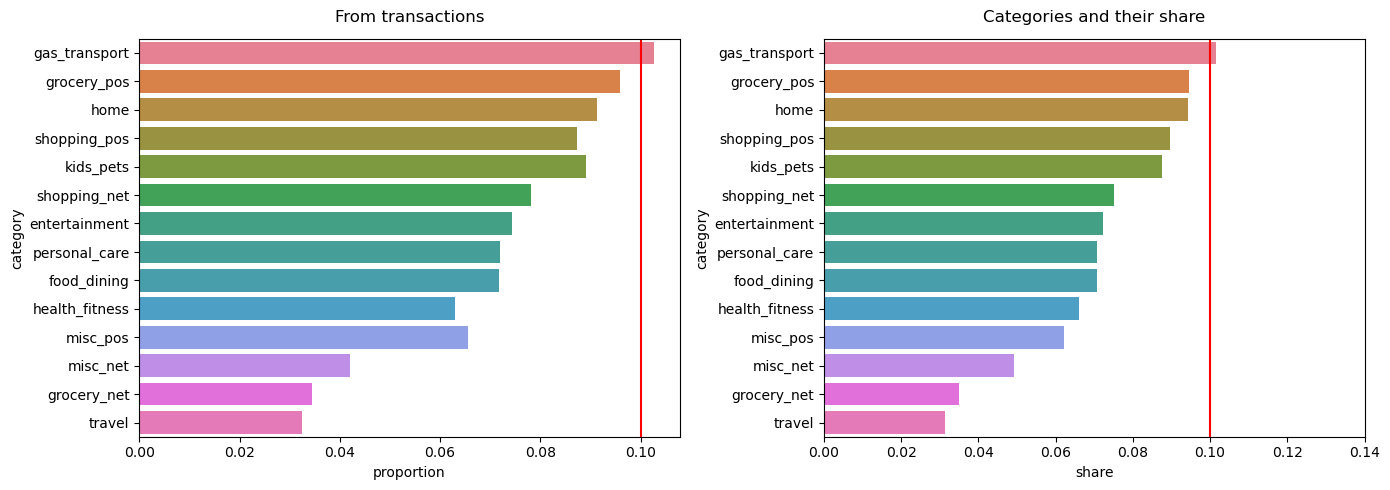

In [719]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

sns.barplot(data=cat_props_merged, x="proportion", y="category", hue="category", ax=ax[0])
ax[0].axvline(x=0.1, color="red")
ax[0].set_title("From transactions", pad=12)
sns.barplot(data=cat_props_merged, x="share", y="category", hue="category", ax=ax[1])
ax[1].axvline(x=0.1, color="red")
ax[1].set_title("Categories and their share", pad=12)
ax[1].set_xlim(0, 0.14)
plt.tight_layout();

In [485]:
# Проверка многократным семплированием категорий с переданными весами. 
# Для проверки того что все работает как надо при семплировании

cat_sample_150 = cat_stats_full.category.sample(6000, weights=cat_stats_full.share, replace=True) \
                                .value_counts(normalize=True).reset_index().merge(cat_stats_full, how="left", on="category") \
                                .sort_values("share", ascending=False)

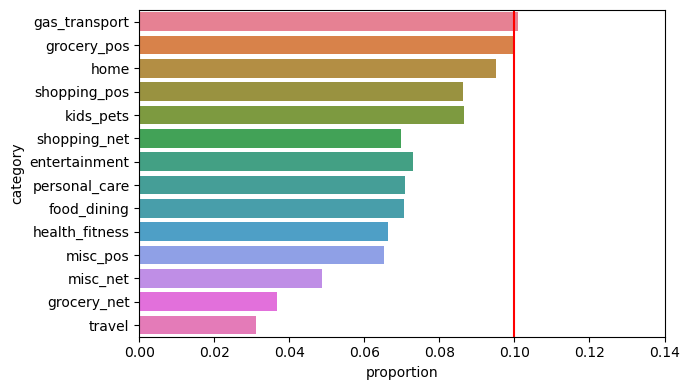

In [486]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

sns.barplot(data=cat_sample_150, x="proportion", y="category", hue="category", ax=ax)
ax.axvline(x=0.1, color="red")
ax.set_xlim(0, 0.14)
plt.tight_layout();

**Проверка распределения времени по категориям**

In [720]:
multi_legit_trans_test.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m
0,81,2025-01-01 08:03:00,1735718580,460.532257,purchase,POS,grocery_pos,False,2661.0,Уфа,54.695949,56.082366,not applicable,NaN,False,False,approved,not applicable,NaN,NaN
1,85,2025-01-01 08:40:00,1735720800,1004.245495,purchase,POS,gas_transport,False,2544.0,Москва,55.787266,37.768107,not applicable,NaN,False,False,approved,not applicable,NaN,NaN
2,53,2025-01-01 08:59:00,1735721940,1744.058788,purchase,POS,grocery_pos,False,4290.0,Нижний Новгород,56.316198,43.992360,not applicable,NaN,False,False,approved,not applicable,NaN,NaN
3,4,2025-01-01 08:59:00,1735721940,1098.129571,purchase,POS,kids_pets,False,6033.0,Ростов-на-Дону,47.195839,39.634940,not applicable,NaN,False,False,approved,not applicable,NaN,NaN
4,70,2025-01-01 09:11:00,1735722660,5148.653108,purchase,POS,shopping_pos,False,2568.0,Новосибирск,54.892692,83.067757,not applicable,NaN,False,False,approved,not applicable,NaN,NaN


In [721]:
cat_stats_full

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154,0.002732,True
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568,485,0.009229,True
2,home,579.954129,480.852810,52345,False,0.094193,67,0.001280,False
3,shopping_pos,768.624573,2324.846777,49791,False,0.089597,213,0.004278,False
4,kids_pets,575.069126,487.484822,48692,False,0.087620,65,0.001335,False
5,shopping_net,834.816532,2372.197581,41779,True,0.075180,506,0.012111,True
6,entertainment,639.848399,642.299347,40104,False,0.072166,59,0.001471,False
7,personal_care,482.330206,494.109413,39327,False,0.070768,70,0.001780,False
8,food_dining,507.779383,484.490535,39268,False,0.070662,54,0.001375,True
9,health_fitness,538.674317,479.652511,36674,False,0.065994,52,0.001418,False


In [722]:
# джоин флага round clock к транзакциям. для разделения на сабсеты: оффлайн 24 часа, онлайн, оффлайн день

multi_legit_and_cats = multi_legit_trans_test.merge(cat_stats_full[["category", "round_clock"]].copy(), on="category")
multi_legit_and_cats.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m,round_clock
0,81,2025-01-01 08:03:00,1735718580,460.532257,purchase,POS,grocery_pos,False,2661.0,Уфа,54.695949,56.082366,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,True
1,85,2025-01-01 08:40:00,1735720800,1004.245495,purchase,POS,gas_transport,False,2544.0,Москва,55.787266,37.768107,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,True
2,53,2025-01-01 08:59:00,1735721940,1744.058788,purchase,POS,grocery_pos,False,4290.0,Нижний Новгород,56.316198,43.992360,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,True
3,4,2025-01-01 08:59:00,1735721940,1098.129571,purchase,POS,kids_pets,False,6033.0,Ростов-на-Дону,47.195839,39.634940,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,False
4,70,2025-01-01 09:11:00,1735722660,5148.653108,purchase,POS,shopping_pos,False,2568.0,Новосибирск,54.892692,83.067757,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,False


In [723]:
multi_legit_offline_24 = multi_legit_and_cats.query("online == False and round_clock == True")
multi_legit_offline_24.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m,round_clock
0,81,2025-01-01 08:03:00,1735718580,460.532257,purchase,POS,grocery_pos,False,2661.0,Уфа,54.695949,56.082366,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,True
1,85,2025-01-01 08:40:00,1735720800,1004.245495,purchase,POS,gas_transport,False,2544.0,Москва,55.787266,37.768107,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,True
2,53,2025-01-01 08:59:00,1735721940,1744.058788,purchase,POS,grocery_pos,False,4290.0,Нижний Новгород,56.316198,43.992360,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,True
6,10,2025-01-01 09:41:00,1735724460,533.145053,purchase,POS,grocery_pos,False,6551.0,Калуга,54.537585,36.189258,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,True
7,42,2025-01-01 09:53:00,1735725180,473.100057,purchase,POS,gas_transport,False,5153.0,Самара,53.191363,50.205783,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,True


In [724]:
multi_legit_online = multi_legit_and_cats.query("online == True")
multi_legit_online.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m,round_clock
29,15,2025-01-01 14:10:00,1735740600,3417.916056,purchase,ecom,shopping_net,True,6810.0,Липецк,52.610303,39.594627,2.60.0.15,NaN,False,False,approved,not applicable,NaN,NaN,True
39,101,2025-01-01 14:53:00,1735743180,1171.212995,purchase,ecom,misc_net,True,6935.0,Самара,53.195166,50.106769,2.60.0.96,NaN,False,False,approved,not applicable,1.735739e+09,66.0,True
42,43,2025-01-01 15:25:00,1735745100,526.833855,purchase,ecom,grocery_net,True,6788.0,Калининград,54.707322,20.507246,2.60.0.41,NaN,False,False,approved,not applicable,NaN,NaN,True
44,17,2025-01-01 15:38:00,1735745880,1.000000,purchase,ecom,shopping_net,True,6878.0,Тюмень,57.153082,65.534312,2.60.0.17,NaN,False,False,approved,not applicable,NaN,NaN,True
59,56,2025-01-01 17:26:00,1735752360,601.770116,purchase,ecom,grocery_net,True,6919.0,Липецк,52.610303,39.594627,2.60.0.53,NaN,False,False,approved,not applicable,1.735741e+09,184.0,True


In [725]:
multi_legit_offline_day = multi_legit_and_cats.query("online == False and round_clock == False")
multi_legit_offline_day.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m,round_clock
3,4,2025-01-01 08:59:00,1735721940,1098.129571,purchase,POS,kids_pets,False,6033.0,Ростов-на-Дону,47.195839,39.634940,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,False
4,70,2025-01-01 09:11:00,1735722660,5148.653108,purchase,POS,shopping_pos,False,2568.0,Новосибирск,54.892692,83.067757,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,False
5,107,2025-01-01 09:24:00,1735723440,1236.818847,purchase,POS,kids_pets,False,848.0,Москва,55.737404,37.680317,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,False
10,6,2025-01-01 10:33:00,1735727580,3970.201918,purchase,POS,shopping_pos,False,5030.0,Петрозаводск,61.784791,34.316156,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,False
12,41,2025-01-01 10:44:00,1735728240,283.670604,purchase,POS,personal_care,False,2327.0,Чита,52.022694,113.210426,not applicable,NaN,False,False,approved,not applicable,NaN,NaN,False


In [726]:
# Проверка есть ли транзакции из дневной категории выходящие за установленные пределы по времени
# для этой категории - 08:00-21:59

multi_legit_offline_day.loc[(multi_legit_offline_day.txn_time.dt.hour < 8) | (multi_legit_offline_day.txn_time.dt.hour > 21)]

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m,round_clock


**Визуализация того, как распределено время транзакций по часам согласно их типу:**<br>
- оффлайн 24 часа, онлайн, дневной оффлайн

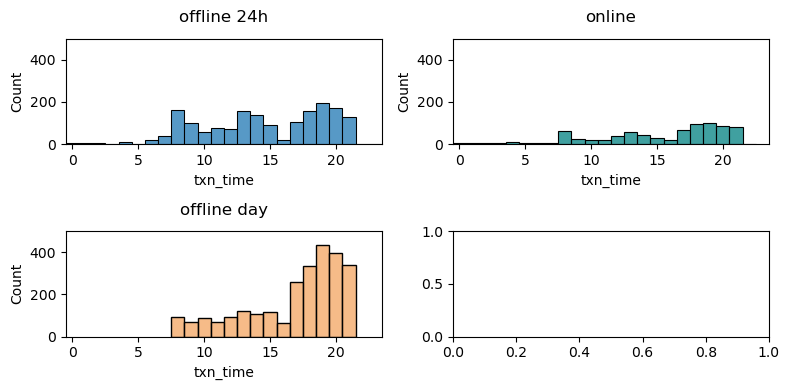

In [729]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,4))
titles = [["offline 24h", "online"], ["offline day"]]

sns.histplot(x=multi_legit_offline_24.txn_time.dt.hour, binwidth=1, discrete=True, ax=axes[0,0])
sns.histplot(x=multi_legit_online.txn_time.dt.hour, binwidth=1, discrete=True, color="teal", ax=axes[0,1])
p = sns.histplot(x=multi_legit_offline_day.txn_time.dt.hour, binwidth=1, discrete=True, color="sandybrown", ax=axes[1,0])

for row, title_pair in zip(axes, titles):
    for ax, title in zip(row, title_pair):
        ax.set_xlim(-0.5, 23.5)
        ax.set_ylim(0, 500)
        ax.set_title(title, pad=12)
plt.tight_layout()
plt.show()

**Проверка средних сумм транзакций и стандартного отклонения сумм по категориям**

In [737]:
multi_legit_amt_avg_std = multi_legit_trans_test.groupby("category", as_index=False).agg({"amount":["mean","std"]})
multi_legit_amt_avg_std.columns = ["category", "avg_amt_real", "amt_std_real"]
multi_leg_amt_check_merged = multi_legit_amt_avg_std.merge(cat_stats_full[["category", "avg_amt", "amt_std"]], on="category")
multi_leg_amt_check_perc = pd.DataFrame(index=multi_legit_amt_avg_std.index, columns=["category", "avg_change","std_change"])

# Посчитаем на сколько процентов отличаются фактические среднее и стандартное отклонение от образца
multi_leg_amt_check_perc["category"] = multi_legit_amt_avg_std["category"]
multi_leg_amt_check_perc["avg_change"] = multi_leg_amt_check_merged.avg_amt_real.div(multi_leg_amt_check_merged.avg_amt).mul(100).sub(100)
multi_leg_amt_check_perc["std_change"] = multi_leg_amt_check_merged.amt_std_real.div(multi_leg_amt_check_merged.amt_std).mul(100).sub(100)

# Трансформация данных в длинный формат для построения двух графиков в seaborn
multi_leg_amt_check_perc_melt = multi_leg_amt_check_perc.melt(id_vars=["category"], value_vars=["avg_change", "std_change"], \
                                                        value_name="value", var_name="measure")
multi_leg_amt_check_perc_melt.iloc[np.r_[0:3,-3:0]]

,category,measure,value
0,entertainment,avg_change,11.819759
1,food_dining,avg_change,10.578180
2,gas_transport,avg_change,0.336440
25,shopping_net,std_change,-29.092625
26,shopping_pos,std_change,-33.609654
27,travel,std_change,-41.618711


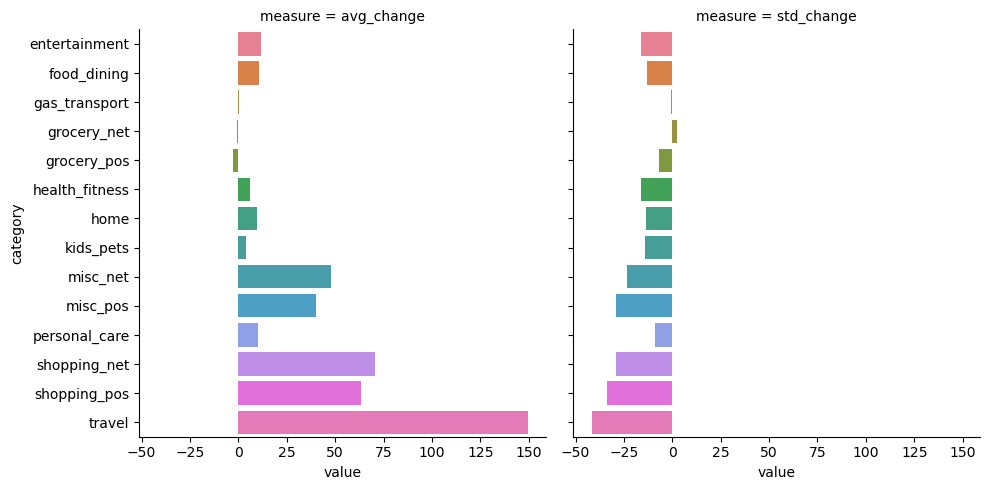

In [739]:
sns.catplot(x="value", y="category", col="measure", hue="category", kind="bar", data=multi_leg_amt_check_perc_melt);

Видимо у категорий у которых большое std, у тех и среднее сильнее отклоняется - имеется в виду график выше.  
Ниже график сравнения отклонений фактического среднего от среднего которое бралось для генерации и  
распределение стандартных отклонений которые использовались при генерации.  
Чтобы посмотреть зависимость

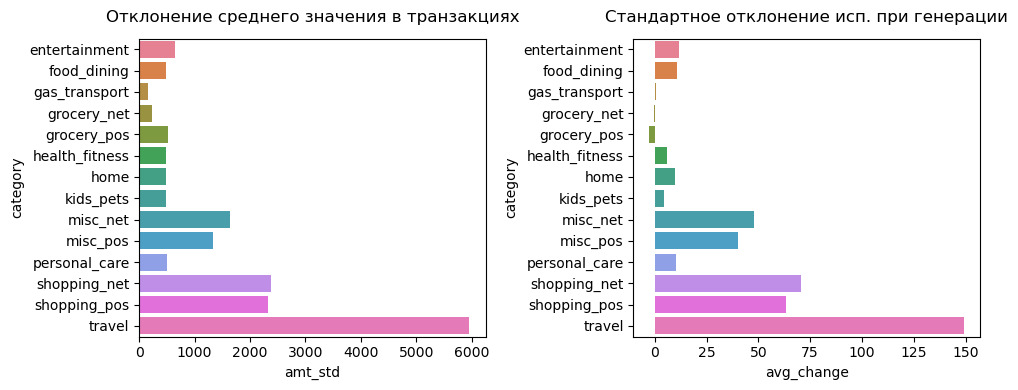

In [744]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.barplot(data=cat_stats_full[["category","amt_std"]].sort_values("category"), \
            x="amt_std", y="category", hue="category", ax=ax[0])
sns.barplot(data=multi_leg_amt_check_perc.sort_values("category"), \
            x="avg_change", y="category", hue="category", ax=ax[1])
ax[0].set_title("Отклонение среднего значения в транзакциях", pad=12)
ax[1].set_title("Стандартное отклонение исп. при генерации", pad=12)
plt.tight_layout();

**Проверка что города мерчантов совпадают с городами клиентов т.к. это легальные транзакции**

In [745]:
multi_legit_trans_test.merge(offline_merchants, on="merchant_id") \
                    .query("trans_city != area")

,client_id,txn_time,unix_time,amount,type,channel,category_x,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m,district_code,region,area,timezone,population,clients,category_y,avg_amt,amt_std,cat_count,merchant_lat,merchant_lon,geometry


**Проверка что id онлайн мерчантов это id только от онлайн мерчантов, без оффлайн**

In [746]:
# Фильтрация по online и инверсия фильтрации по online_merchant_ids
# Если датафрейм на выходе пустой, то нет онлайн транзакций где id мерчанта взят из оффлайн

multi_legit_trans_test[(multi_legit_trans_test.online == True) & ~(multi_legit_trans_test.merchant_id.isin(online_merchant_ids))]

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m


In [747]:
# такая же проверка для оффлайн мерчантов

multi_legit_trans_test[(multi_legit_trans_test.online == False) \
& ~(multi_legit_trans_test.merchant_id.isin(offline_merchants.merchant_id))]

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m


In [748]:
# проверка на пустые значения.

multi_legit_trans_test.isna().sum()

client_id              0
txn_time               0
unix_time              0
amount                 0
type                   0
channel                0
category               0
online                 0
merchant_id            0
trans_city             0
trans_lat              0
trans_lon              0
trans_ip               0
account_to          5083
is_fraud               0
is_suspicious          0
status                 0
rule                   0
prev_txn_unix        103
prev_time_diff_m     103
dtype: int64

# Генерация транзакций частями и запись в `parquet`
См. Запись транзакций чанками в файлы - GPT

In [687]:
timestamps = create_timestamps_range_df(start="2025-01-01", end="2025-01-31")
# Он тут не играет роли, т.к. генерируем всего за месяц. Но это задел для случаев когда взят период более одного месяца
timestamps_1st_month = timestamps.loc[timestamps.timestamp.dt.month == timestamps.timestamp.dt.month.min()].copy()

In [692]:
time_weights_dict = get_all_time_patterns(time_weight_args)

In [693]:
trans_df = transactions.copy()
trans_df

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,account_to,is_fraud,is_suspicious,status,rule


In [ ]:
# gen_multiple_legit_trans(clients_df=clients_with_geo_subset, trans_df=trans_for_test_multi, \
#                                                   offline_merchants=offline_merchants, timestamps=timestamps_multi_legit, \
#                                                   timestamps_1st_month=timestamps_1st_month, \
#                                                  categories=cat_stats_full,  online_merchant_ids=online_merchant_ids, \
#                                                   time_weights_dict=time_weights_dict_multi_leg)

In [ ]:
# for client in clients_with_geo.query("client_id == 1").itertuples():
#     print(client.birth_date)

In [ ]:
# from datetime import datetime

In [ ]:
# class Client:
#     def __init__(self, id, city, ip, dob):
#         self.id = id
#         self.city = city
#         self.ip = ip
#         self.dob = pd.to_datetime(dob)

#     def age(self):
#         today = datetime.today().date()
#         age = (pd.to_datetime(today) - self.dob).components.days
#         return age

In [ ]:
# client = Client(1, "Moscow", "127.0.0.1", "1990-06-06")

In [ ]:
# client.age()

In [ ]:
# %%time
# trans_gen_test_01 = generate_pos_transactions(client_info=clients_with_geo_subset, start_date="2021-01-01", end_date="2021-12-31", \
#                                               time_weights_dict=time_weights, categories=cat_stats_full, rules=rules_df, fraud_ips=fraud_ips, \
#                                               trans_df=trans_for_test, merchants_df=offline_merchants, \
#                                               online_merchant_ids=online_merchant_ids, num=100, fraud_rate=0.01)

In [ ]:
# trans_gen_test_01.sort_values("txn_time")

In [ ]:
800 / 5369

In [ ]:
5369 * 0.15

# Урезание количества клиентов
**Думаю просто можно равновероятно семплировать n клиентов и все, без ухищрений как внизу**  
Т.к. на ~5400 клиентов нужно очень много транзакций, чтобы у каждого их было хотя бы 50.  
Условно 270000 транзакций по 50 на 5400 клиентов. Скорее всего генерироваться будут больше часа

In [ ]:
# на данный момент примерно до 800.

clients_reduced_num = pd.DataFrame(districts_ru.clients.mul(0.15).round().astype("int"))
clients_reduced_num["city"] = districts_ru["area"].copy()
clients_reduced_num

In [ ]:
clients_reduced_df = gpd.GeoDataFrame(columns=clients_with_geo.columns)
# clients_reduced_df.columns = 
for col, data_type in clients_with_geo.dtypes.items():
    # if data_type != "geometry" print(data_type)
    clients_reduced_df[col] = clients_reduced_df[col].astype(f"{data_type}")
# list(zip(clients_with_geo.dtypes.items(), clients_reduced_df.columns))
clients_reduced_df.dtypes

In [ ]:
for row in clients_reduced_num.itertuples():
    clients_with_geo_part = clients_with_geo.loc[clients_with_geo["area"] == row.city].iloc[0:row.clients]
    clients_reduced_df = pd.concat([clients_reduced_df,clients_with_geo_part])

In [ ]:
clients_reduced_df

In [665]:
# merchant = offline_merchants.loc[(offline_merchants["area"] == "Нижний Новгород") \
#                                & (offline_merchants.category == "gas_transport")].sample(1, replace=True)
# merchant_id = merchant["merchant_id"].iloc[0]
# merchant_loc = merchant["geometry"].iloc[0]
# type(merchant_loc)

In [ ]:
# for row in clients_with_geo[:2].itertuples():

#     print(row)
#     # данные клиента
#     client_id = row.client_id
#     client_area = row.area
#     client_area_geometry = row.geometry
#     client_ip = row.home_ip
# type(client_area_geometry)
# clients_with_geo.head(2)

In [666]:
# legit_merge_hour_and_total = legit_by_cat_and_hour.merge(legit_kaggle_by_cat, on="category") \
#                                                 [["category", "trans_hour", "trans_count", "total_trans"]] \
#                                                 .sort_values(["category", "trans_hour"])
# legit_merge_hour_and_total.shape

In [ ]:
# legit_merge_hour_and_total["hour_share"] = legit_merge_hour_and_total.trans_count.div(legit_merge_hour_and_total.total_trans)
# legit_merge_hour_and_total.head()

In [ ]:
# fig, axes = plt.subplots(nrows=cat_stats_full.shape[0], figsize=(10, 60))

# # df = legit_merge_hour_and_total.query("category == 'health_fitness'")
# for ax, category in zip(axes, cat_stats_full["category"]):
#     sns.lineplot(data=legit_merge_hour_and_total.query("category == @category"), x="trans_hour", y="hour_share", ax=ax)
#     ax.set_title(category)
#     ax.set_ylim(0)
# plt.tight_layout()    
# plt.show()

In [ ]:
# df = legit_merge_hour_and_total.query("category == 'grocery_pos'")

# p = sns.barplot(data=df, x="trans_hour", y="trans_count")
# p.set_ylim(0);

In [ ]:
# # Генерация POS транзакций
# def generate_pos_transactions(client_info, start_date, end_date, categories, fraud_ips, trans_df, merchants_df \
#                               ,online_merchant_ids, num=50, fraud_rate=0.05):
#     """
#     client_info  - датафрейм с данными клиента
#     start_date - первая транзакция
#     end_date - последняя транзакция
#     num - количество транзакций на клиента
#     fraud_rate - доля фрода во всех транзакциях
#     categories - датафрейм с категориями и их характеристиками
#     fraud_ips - датафрейм с фродовыми ip адресами
#     trans_df - датафрейм с транзакциями.
#                Куда их писать и куда обращаться за информацией по предыдущим транзакциям
#     merchants_df - датафрейм с оффлайн мерачантами
#     online_merchant_ids - id для онлайн мерчантов
#     """
#     timestamps = pd.Series(pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='min'))
    
#     day_time = timestamps[(timestamps.dt.hour >= 6) & (timestamps.dt.hour < 22)].reset_index(drop=True)
#     night_time = timestamps[((timestamps.dt.hour < 6) & (timestamps.dt.hour >= 0)) \
#                 | (timestamps.dt.hour >= 22) & (timestamps.dt.hour <= 23)] \
#                 .reset_index(drop=True)

#     def get_time_for_trans(trans_df, client_id, round_clock_cat, is_fraud):
#         # дата и время последней транзакции клиента
#         last_txn_time = trans_df[trans_df.client_id == client_id].time.max()
        
#         # если нет предыдущей транзакции
#         if last_txn_time is np.nan:
#             if round_clock_cat == 1 and not is_fraud:
#                 txn_time = timestamps.sample(n=1, weights=, replace=True).iloc[0]

#             else:
#                 txn_time = day_time.sample(n=1, replace=True).iloc[0]

#         # если есть предыдущая транзакция
#         else:
#             txn_time = timestamps.sample(n=1, replace=True).iloc[0]
#             trans_time_diff = txn_time - last_txn_time
#             one_hour_delta = pd.Timedelta(3600, unit="s")

#             # если время между текущей и последней транзакцией меньше часа, то добавим время чтобы было час минимум
#             if trans_time_diff < one_hour_delta:
#                 time_addition = one_hour_delta - trans_time_diff
#                 txn_time = txn_time + time_addition
    
#     for lab, row in client_info.iterrows():
#         pos_txns = [] # сюда временно будут добавляться созданные транзакции для текущего клиента

        
#         # данные клиента
#         client_id = client_info.loc[lab, "client_id"]
#         client_area = client_info.loc[lab, "area"]
#         client_area_geometry = client_info.loc[lab, "geometry"]
#         client_ip = client_info.loc[lab, "home_ip"]

#         # цикл создания n транзакций для текущего клиента
#         for _ in range(num):
            
                    
#             # случайный выбор категории транзакции    
#             category = categories.sample(1, replace=True, weights=categories.share)
#             category_name = category["category"].iloc[0]
#             round_clock = category["round_clock_cat"].iloc[0]
#             # средняя сумма для этой категории
#             amt_mean = category["avg_amt"].iloc[0]
#             # стандартное отклонение сумм для этой категории
#             amt_std = category["amt_std"].iloc[0]
#             # случайно сгенерированная сумма не менее 1
#             amount = max(1, np.random.normal(amt_mean, amt_std))

#             # будет ли транзакция фродом или нет. 
#             is_fraud = random.random() < fraud_rate

#             # генерация данных для оффлайн покупок - не фрод
#             if category["online"].iloc[0] == 0 and not is_fraud:
#                 merchant = merchants_df.loc[(merchants_df.area == client_area) & (merchants_df.category == category_name)].sample(1, replace=True)
#                 merchant_id = merchant["merchant_id"].iloc[0]
#                 merchant_loc = merchant["merchant_loc"].iloc[0]
                
#                 pos_txns.append({
#                 "client_id": client_id, "time": txn_time, "amount": round(amount, 2), "type": "purchase",
#                 "channel": "POS", "category": category_name, "online": category["online"].iloc[0],
#                 "merchant_id": merchant_id, "merchant_loc": merchant_loc, "is_fraud": is_fraud
#             })

#             trans_df_one_client = pd.DataFrame(pos_txns)
#         trans_df = pd.concat([trans_df, trans_df_one_client], ignore_index=True)

#     return trans_df

In [ ]:
# amounts = []
# category = cat_stats_full.sample(1, replace=True, weights=cat_stats_full.share)
# for _ in range(100):

    
#     amt_mean = category["avg_amt"].iloc[0]
#     amt_std = category["amt_std"].iloc[0]
#     amount = max(1, np.random.normal(amt_mean, amt_std))

#     amounts.append(amount)
#     # print(f"""
#     # Category: {category["category"]}
#     # Amount: {amount}
#     # """)

# print(f"""Category: {category["category"]}""")
# pd.Series(amounts).mean()

In [ ]:
# cat_stats_full.query("category == @category['category'].iloc[0]")

### Часть от оригинальной функции от GPT

In [ ]:
                
            # генерация данных для онлайн покупок: ip
            # if category["online"] == 1:
                
            # Гео — нормальный город
            # city = random.choice(list(city_coords.keys()))
            # lat, lon = city_coords[city]
            # lat += np.random.normal(0, 0.01)
            # lon += np.random.normal(0, 0.01)
    
            
            # if is_fraud:
            #     # Фрод: другой город, высокая сумма, необычная категория
            #     category = "luxury"
            #     amount = np.random.uniform(20000, 150000)
            #     lat += np.random.normal(5, 2)  # далеко
            #     lon += np.random.normal(5, 2)
    
            # pos_txns.append({
            #     "client_id": client_id,
            #     "date": txn_date,
            #     "amount": round(amount, 2),
            #     "type": "purchase",
            #     "channel": "POS",
            #     "category": category,
            #     "latitude": lat,
            #     "longitude": lon,
            #     "is_fraud": is_fraud
            # })

    # return pd.DataFrame(pos_txns)

# Внизу образец генерации транзакций от GPT

In [ ]:
# import random
# from datetime import timedelta

# # Категории и примерные средние суммы (можно расширить)
# categories = {
#     "grocery": (300, 100),
#     "electronics": (10000, 5000),
#     "transport": (150, 50),
#     "restaurants": (800, 200),
#     "clothing": (2000, 800)
# }

# # Список городов с координатами
# city_coords = {
#     "Москва": (55.75, 37.62),
#     "Санкт-Петербург": (59.94, 30.31),
#     "Казань": (55.79, 49.12),
#     "Екатеринбург": (56.84, 60.61)
# }

In [ ]:
# # Генерация POS транзакций
# def generate_pos_transactions(account_id, client_id, start_date, end_date, num=50, fraud_rate=0.05):
#     dates = pd.date_range(start_date, end_date, freq='D').to_pydatetime().tolist()
#     pos_txns = []

#     for _ in range(num):
#         txn_date = random.choice(dates)
#         category = random.choice(list(categories.keys()))
#         mean, std = categories[category]
#         amount = max(1, np.random.normal(mean, std))

#         # Гео — нормальный город
#         city = random.choice(list(city_coords.keys()))
#         lat, lon = city_coords[city]
#         lat += np.random.normal(0, 0.01)
#         lon += np.random.normal(0, 0.01)

#         is_fraud = random.random() < fraud_rate
#         if is_fraud:
#             # Фрод: другой город, высокая сумма, необычная категория
#             category = "luxury"
#             amount = np.random.uniform(20000, 150000)
#             lat += np.random.normal(5, 2)  # далеко
#             lon += np.random.normal(5, 2)

#         pos_txns.append({
#             "account_id": account_id,
#             "client_id": client_id,
#             "date": txn_date,
#             "amount": round(amount, 2),
#             "type": "purchase",
#             "channel": "POS",
#             "category": category,
#             "latitude": lat,
#             "longitude": lon,
#             "is_fraud": is_fraud
#         })

#     return pd.DataFrame(pos_txns)

## Нормальное распределение

In [ ]:
# 56.310481, 43.989214

In [ ]:
# 56.335365, 43.922722 # std


In [ ]:
# 56.335365 - 56.304909

In [ ]:
# 43.989214 - 43.922722

In [ ]:
# from shapely.geometry import Point, Polygon

# def Random_Points_in_Bounds_Normal(polygon, number, mean_x, mean_y, std_x, std_y):   
    
#     x = np.random.normal(mean_x, std_x, number)
#     y = np.random.normal(mean_y, std_y, number)
#     return x, y

In [ ]:
# nn_poly = district_ru_merge.query("area == 'Нижний Новгород'").iloc[0,-1]

In [ ]:
# gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[nn_poly])
# gdf_poly

In [ ]:
# x,y = Random_Points_in_Bounds_Normal(nn_poly, 1000, mean_x=43.989214, mean_y= 56.310481, std_x=0.066491999, std_y=0.030456)
# df = pd.DataFrame()
# df['points'] = list(zip(x,y))
# df['points'] = df['points'].apply(Point)
# gdf_points = gpd.GeoDataFrame(df, geometry='points')

In [ ]:
# Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

# # Keep points in "myPoly"
# pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']

# # Plot result
# base = gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
# gdf_points.plot(ax=base, linewidth=1, color="red", markersize=8)
# plt.show()

In [672]:
# ru_cities_tent_subset.crs

**Расчет расстояния между двух координат - через Geod**

In [671]:
# from shapely.ops import transform
# from pyproj import Geod

# # Две координаты: (долгота, широта)
# coord1 = (37.617698, 55.755864)   # Москва
# coord2 = (131.885494, 43.115542)   # Владивосток 6434+ km

# # Геодезический расчёт по эллипсоиду WGS84
# geod = Geod(ellps="WGS84")
# distance_m = geod.inv(coord1[0], coord1[1], coord2[0], coord2[1])[-1]

# print(f"Расстояние: {distance_m / 1000:.2f} км")

In [ ]:
# files = os.listdir()
# files
# name_part = "10_kalin_ru"

# for file in files:
#     file_split =  file.split(".")
#     if file_split[0] == "gis_osm_places_a_free_1":
#         new_name = name_part + "." + file_split[-1]
#         print(new_name)
#         os.rename(file, new_name)
    # elif file_split[0] == "07_ural_ru":
    #     new_name = name_part + "." + file_split[-1]
    #     print(new_name)
    #     os.rename(file, new_name)
        
# os.rename("test.txt", "renamed")
# "asdasd.shp".split(".")[-1]

In [ ]:
# os.chdir("./data/raw_data/geo/")

In [ ]:
# gpd.read_file("data/raw_data/geo/01_central_ru.shp")

In [ ]:
# # ru_city_shapes = 
# pd.concat([gpd.read_file(f"./data/raw_data/geo/{file}").query("fclass == 'city'") for file in geo_files])

In [ ]:
# os.chdir("C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01\\")

# Старый код, функции и т.д.

# Функция генерации весов для часов в периоде времени `get_time_for_trans` - Не модульная. Старая версия

In [ ]:
# def get_time_for_trans(trans_df, client_id, is_fraud, time_weights, timestamps, online=None, rule=None, geo_distance=None, lag=None):
#     """
#     trans_df - датафрейм с транзакциями. Откуда брать информацию по предыдущим транзакциям
#     client_id - id клиента, число, клиент чьи транзакции проверяются
#     is_fraud - boolean. Фрод или не фрод
#     time_weights - датафрейм с весами часов в периоде времени
#     timestamps - датафрейм с timestamps
#     online - boolean. Онлайн или оффлайн покупка. True or False
#     rule - строка. Название антифрод правила
#     geo_distance - число. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в метрах
#     lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
#           Это задержка именно между последней легитимной транзакцией и серией частых транзакций. Подразумевается что функция
#           get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.

#     Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
#     """
    
#     # timestamp последней транзакции клиента - может быть вынести фильтрацию по client_id из функции?
#     # Хотя наверное и вне функции все равно надо будет каждый раз обновлять состояние перед генерацией новой транзакции
    
#     last_txn_time = trans_df[trans_df.client_id == client_id].txn_time.max()
#     last_txn_unix = trans_df[trans_df.client_id == client_id].unix_time.max()
    
#     # Если нет предыдущей транзакции т.е. нет последнего времени
#     if not is_fraud and last_txn_time is pd.NaT:
#         # берем первый год всего времененного периода т.к. это первая транзакция, пусть будет создана в первом году
#         timestamps_1st_year = timestamps.loc[timestamps.timestamp.dt.year == timestamps.timestamp.dt.year.min()]

#         # семплируем час из весов времени, указав веса для семплирования
#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         # фильтруем основной датафрейм с диапазоном таймстемпов по этому часу
#         timestamps_subset = timestamps_1st_year.loc[timestamps_1st_year.hour == txn_hour]
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = (txn_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

#     # Если есть предыдущая транзакция

#     # Не фрод. Но есть предыдущая транзакция
#     elif not is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         pos_one_hour_diff = 3600
#         neg_one_hour_diff = -3600
        
#         # если время между текущей и последней транзакцией меньше часа в положительную сторону,
#         # то увеличим время чтобы разница была минимум час 
#         if trans_time_diff < pos_one_hour_diff and trans_time_diff >= 0:
#             time_addition = pos_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_addition
#             txn_time = pd.to_datetime(txn_unix, unit="s")
        
#         # если время между текущей и последней транзакцией меньше часа в отрицательную сторону, 
#         # то уменьшим время чтобы разница была минимум час
#         elif trans_time_diff > neg_one_hour_diff and trans_time_diff < 0:
#             time_subtraction = neg_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_subtraction
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
#     elif is_fraud and rule in ["fast_geo_change", "fast_geo_change_online"]:
#         # Выставим порог скорости перемещения между точками транзакций - м/с
#         # выше порога - детект как фрода. 
#         # Это нужно чтобы генерировать соответствующее время в зависимости от дистанции между точками транзакций
#         # пусть будет порог в 800 км/ч. Делим на 3.6 для перевода в м/с
#         speed_threshold = 800 / 3.6
        
#         # Случайно сгенерированная фактическая скорость превышающая легитимный порог. Допустим от 801 до 36000 км/ч
#         # до 36000 км/ч т.к. грубо говоря транзакция может быть совершена через 20 минут в 9000 км от предыдущей т.е. как-будто бы скорость 36000 км/ч
#         # 9000 км взяты как весьма примерное, самое длинное возможное расстояние между городами России при путешествии самолетом.
#         # но в зависимости от расстояния мы берем разные границы для распределений, чтобы не было перекоса в очень быстрое время. 
#         # Также 20 минут я случайно взял как средний интервал для подобной фрод транзакции.
#         # Конечно же "скорость перемещения" может быть и больше в реальной жизни
        
#         if geo_distance < 1000_000:
#             fact_speed = random.randint(speed_threshold + 1, 3000) / 3.6
#         elif geo_distance >= 1000_000 and geo_distance <= 3000_000:
#             fact_speed = random.randint(speed_threshold + 1, 9000) / 3.6
#         elif geo_distance > 3000_000 and geo_distance <= 6000_000:
#             fact_speed = random.randint(speed_threshold + 1, 18000) / 3.6
#         else:
#             fact_speed = random.randint(speed_threshold + 1, 36000) / 3.6

#         # интервал времени между последней транзакцией и текущей фрод транзакцией
#         time_interval = geo_distance / fact_speed
        
#         txn_unix = last_txn_unix + time_interval
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Увеличение количества транзакций в единицу времени выше установленного порога в процентах.
#     # генерируем время
#     elif is_fraud and rule == "trans_freq_increase":
#         # семплируем таймстемп из таймстемпов по времени не ранее последней транзакции
#         timestamp_sample = timestamps.loc[timestamps.timestamp > last_txn_time].sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         lag_interval = 1800

#         # частота фрод транзакций. от 1 до 5 минут. Выразим в секундах для удобства
#         freq = random.randint(1, 5) * 60
        
#         # если транзакция первая в серии фрод транзакций - аргумент lag=True
#         # и интервал между последней транзакцией менее 30 минут
#         # прибавить интервал 30 минут к семплированному времени текущей транзакции
#         if lag and trans_time_diff < lag_interval:
#             txn_unix = timestamp_sample.unix_time + lag_interval
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # Если lag=True, но не надо добавлять интервал
#         elif lag:
#             txn_unix = timestamp_sample.unix_time
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # для остальных случаев - когда это не первые фрод транзакции в серии
#         else:
#             txn_unix = last_txn_unix + freq
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Любой другой фрод
#     elif is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)

#         txn_unix = timestamp_sample.unix_time
#         txn_time = timestamp_sample.time

    
#     # время транзакции в виде timestamp и unix time
#     return txn_time, txn_unix
    

## Подфункция `ensure_min_interval_from_last_offline_trans` - когда есть предыдущие оффлайн транзакции и нужно обеспечить минимальный фиксированный интервал между транзакциями<br>
`Отменена`

In [ ]:
# def ensure_min_interval_from_last_offline_trans(last_txn_unix, timestamp_sample, time_diff=3600):
#     """
#     Обеспечивает минимальный фиксированный интервал от последней транзакции
#     -----------------------------------------------
#     last_txn_unix - unix время последней транзакции
#     timestamp_sample - случайно выбранная запись из датафрейма с таймстемпами
#     time_diff - желаемая минимальная разница от последней транзакции
    
#     Если сгенерированное время отличается от времени последней по времени транзакции на разницу меньше установленной
#     То вернет время с минимальной установленной разницей от последней транзакции.
#     Например либо час вперед либо час назад.
    
#     Если сгенерированное время раньше последней транзакции менее чем на time_diff, то вернет время последней транзакции минус time_diff.
#     Т.е. например на час раньше последней.
#     Если сгенерированное время позже последней транзакции менее чем на time_diff, то вернет время позже последней транзакции плюс time_diff.
#     Т.е. например на час позже последней.
#     Если разница в положительную либо в отрицательную сторону больше time_diff, то вернет исходное время без изменений.
#     """
    
#     timestamp_unix = timestamp_sample.unix_time.iloc[0]
#     trans_time_diff = timestamp_unix - last_txn_unix
#     pos_one_hour_diff = time_diff
#     neg_one_hour_diff = - time_diff
    
#     # если время между текущей и последней транзакцией меньше time_diff в положительную сторону,
#     # то увеличим время чтобы разница была минимум time_diff 
#     if trans_time_diff < pos_one_hour_diff and trans_time_diff >= 0:
#         print("Condition #1")
#         time_addition = pos_one_hour_diff - trans_time_diff
#         txn_unix = timestamp_unix + time_addition
#         txn_time = pd.to_datetime(txn_unix, unit="s")
    
#     # если время между текущей и последней транзакцией меньше time_diff в отрицательную сторону, 
#     # то уменьшим время чтобы разница была минимум time_diff
#     elif trans_time_diff > neg_one_hour_diff and trans_time_diff < 0:
#         print("Condition #2")
#         time_subtraction = neg_one_hour_diff - trans_time_diff
#         txn_unix = timestamp_unix + time_subtraction
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # если разница во времени больше установленной
#     else:
#         txn_unix = timestamp_unix
#         txn_time = pd.to_datetime(txn_unix, unit="s")
        
        
#     return txn_time, txn_unix

In [ ]:
# def check_min_interval_from_near_trans(client_txns, timestamp_sample, online, offline_time_diff=60, \
#                                        online_time_diff=6, online_ceil=60, general_diff=30, general_ceil=90):
#     """
#     Если для сгенерированного времени есть транзакции, которые по времени ближе заданного минимума, 
#     то создать время на основании времени последней транзакции + установленный минимальный интервал.
#     Проверяет время либо для оффлайн либо для онлайн транзакций.
#     Для оффлайн и онлайн транзакций можно поставить свои минимальные интервалы.
#     Для онлайн ставится и максимальный интервал. Время берется случайно и равновероятно из диапазона между online_time_diff и online_ceil
#     -----------------------------------------------

#     client_txns - датафрейм с транзакциями клиента.
#     timestamp_sample - случайно выбранная запись из датафрейма с таймстемпами
#     offline_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
#     online_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
#     online_ceil - int. желаемая максимальная разница от последней оффлайн транзакции в минутах
#     general_diff - int. минимально допустимая разница от последней транзакции противоположной по флагу online.
#     general_ceil - int. максимальная разница от последней транзакции противоположной по флагу online.
#                    При случае необходимости увеличения разрыва времени.
#     """
    
#     timestamp_unix = timestamp_sample.unix_time.iloc[0]

#     offline_txns = client_txns.loc[client_txns.online == False]
#     online_txns = client_txns.loc[client_txns.online == True]
    
#     # смотрим ближайшие оффлайн и онлайн транзакции по времени по модулю.
#     # В переменные записываем время по модулю до ближайшей транзакции онлайн или оффлайн типа
#     closest_offline_txn = offline_txns.unix_time.sub(timestamp_unix).abs().min()
#     closest_online_txn = online_txns.unix_time.sub(timestamp_unix).abs().min()

#     # перевод аргументов в секунды для работы с unix time
#     offline_time_diff= offline_time_diff * 60
#     online_time_diff= online_time_diff * 60
#     online_ceil= online_ceil * 60
#     general_diff = general_diff * 60
#     general_ceil = general_ceil * 60
    
#     # Если текущая транзакция - оффлайн и разница с ближайшей транзакцией меньше допустимой
#     if not online and closest_txn_by_time < offline_time_diff:
        
#         # извлекаем время последней оффлайн транзакции и прибавляем установленный интервал
#         last_offline_txn_unix = offline_txns.unix_time.max()
#         txn_unix = last_offline_txn_unix + offline_time_diff
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Если текущая транзакция - онлайн и разница с ближайшей транзакцией меньше допустимой
#     elif online and closest_txn_by_time < online_time_diff:
        
#         # извлекаем время последней онлайн транзакции и прибавляем установленный интервал
#         last_online_txn_unix = online_txns.unix_time.max()

#         # Берем случайное время между online_time_diff и online_ceil
#         online_random_diff = random.randint(online_time_diff, online_ceil)

#         # прибавляем установленный интервал ко времени последней транзакции
#         txn_unix = last_online_txn_unix + online_random_diff
#         txn_time = pd.to_datetime(txn_unix, unit="s")
        
#     # если разница во времени является допустимой. Просто берем текущий timestamp
#     else:
#         txn_unix = timestamp_unix
#         txn_time = pd.to_datetime(txn_unix, unit="s")  
        
    
#     # Проверка есть ли слишком близкие по времени транзакции противоположные по флагу online
#     # Любая последняя транзакция. Если последняя транзакция такая же по флагу online, то разница
#     # Уже проверена и обеспечена в прошлом if-else блоке, и ничего не изменится.
#     last_txn_unix = client_txns.unix_time.max()
#     last_txn_diff = abs(last_txn_unix - txn_unix)
    
#     if last_txn_diff < general_diff:
#         general_random_diff = random.randint(general_diff, general_ceil)
#         txn_unix = last_txn_unix + general_random_diff
#         txn_time = pd.to_datetime(txn_unix, unit="s")
        
#     return txn_time, txn_unix

# Немодульная `get_time_for_trans` - старая версия

# `check_min_interval_from_near_trans` - до рефактора и добавления условий

In [ ]:
# def get_time_for_trans(trans_df, client_id, is_fraud, time_weights, timestamps, online=None, rule=None, geo_distance=None, lag=None):
#     """
#     trans_df - датафрейм с транзакциями. Откуда брать информацию по предыдущим транзакциям
#     client_id - id клиента, число, клиент чьи транзакции проверяются
#     is_fraud - boolean. Фрод или не фрод
#     time_weights - датафрейм с весами часов в периоде времени
#     timestamps - датафрейм с timestamps
#     online - boolean. Онлайн или оффлайн покупка. True or False
#     rule - строка. Название антифрод правила
#     geo_distance - число. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в метрах
#     lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
#           Это задержка именно между последней легитимной транзакцией и серией частых транзакций. Подразумевается что функция
#           get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.

#     Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
#     """
    
#     # timestamp последней транзакции клиента - может быть вынести фильтрацию по client_id из функции?
#     # Хотя наверное и вне функции все равно надо будет каждый раз обновлять состояние перед генерацией новой транзакции
    
#     last_txn_time = trans_df[trans_df.client_id == client_id].txn_time.max()
#     last_txn_unix = trans_df[trans_df.client_id == client_id].unix_time.max()
    
#     # Если нет предыдущей транзакции т.е. нет последнего времени
#     if not is_fraud and last_txn_time is pd.NaT:
#         # берем первый год всего времененного периода т.к. это первая транзакция, пусть будет создана в первом году
#         timestamps_1st_year = timestamps.loc[timestamps.timestamp.dt.year == timestamps.timestamp.dt.year.min()]

#         # семплируем час из весов времени, указав веса для семплирования
#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         # фильтруем основной датафрейм с диапазоном таймстемпов по этому часу
#         timestamps_subset = timestamps_1st_year.loc[timestamps_1st_year.hour == txn_hour]
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = (txn_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

#     # Если есть предыдущая транзакция

#     # Не фрод. Но есть предыдущая транзакция
#     elif not is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         pos_one_hour_diff = 3600
#         neg_one_hour_diff = -3600
        
#         # если время между текущей и последней транзакцией меньше часа в положительную сторону,
#         # то увеличим время чтобы разница была минимум час 
#         if trans_time_diff < pos_one_hour_diff and trans_time_diff >= 0:
#             time_addition = pos_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_addition
#             txn_time = pd.to_datetime(txn_unix, unit="s")
        
#         # если время между текущей и последней транзакцией меньше часа в отрицательную сторону, 
#         # то уменьшим время чтобы разница была минимум час
#         elif trans_time_diff > neg_one_hour_diff and trans_time_diff < 0:
#             time_subtraction = neg_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_subtraction
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
#     elif is_fraud and rule in ["fast_geo_change", "fast_geo_change_online"]:
#         # Выставим порог скорости перемещения между точками транзакций - м/с
#         # выше порога - детект как фрода. 
#         # Это нужно чтобы генерировать соответствующее время в зависимости от дистанции между точками транзакций
#         # пусть будет порог в 800 км/ч. Делим на 3.6 для перевода в м/с
#         speed_threshold = 800 / 3.6
        
#         # Случайно сгенерированная фактическая скорость превышающая легитимный порог. Допустим от 801 до 36000 км/ч
#         # до 36000 км/ч т.к. грубо говоря транзакция может быть совершена через 20 минут в 9000 км от предыдущей т.е. как-будто бы скорость 36000 км/ч
#         # 9000 км взяты как весьма примерное, самое длинное возможное расстояние между городами России при путешествии самолетом.
#         # но в зависимости от расстояния мы берем разные границы для распределений, чтобы не было перекоса в очень быстрое время. 
#         # Также 20 минут я случайно взял как средний интервал для подобной фрод транзакции.
#         # Конечно же "скорость перемещения" может быть и больше в реальной жизни
        
#         if geo_distance < 1000_000:
#             fact_speed = random.randint(speed_threshold + 1, 3000) / 3.6
#         elif geo_distance >= 1000_000 and geo_distance <= 3000_000:
#             fact_speed = random.randint(speed_threshold + 1, 9000) / 3.6
#         elif geo_distance > 3000_000 and geo_distance <= 6000_000:
#             fact_speed = random.randint(speed_threshold + 1, 18000) / 3.6
#         else:
#             fact_speed = random.randint(speed_threshold + 1, 36000) / 3.6

#         # интервал времени между последней транзакцией и текущей фрод транзакцией
#         time_interval = geo_distance / fact_speed
        
#         txn_unix = last_txn_unix + time_interval
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Увеличение количества транзакций в единицу времени выше установленного порога в процентах.
#     # генерируем время
#     elif is_fraud and rule == "trans_freq_increase":
#         # семплируем таймстемп из таймстемпов по времени не ранее последней транзакции
#         timestamp_sample = timestamps.loc[timestamps.timestamp > last_txn_time].sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         lag_interval = 1800

#         # частота фрод транзакций. от 1 до 5 минут. Выразим в секундах для удобства
#         freq = random.randint(1, 5) * 60
        
#         # если транзакция первая в серии фрод транзакций - аргумент lag=True
#         # и интервал между последней транзакцией менее 30 минут
#         # прибавить интервал 30 минут к семплированному времени текущей транзакции
#         if lag and trans_time_diff < lag_interval:
#             txn_unix = timestamp_sample.unix_time + lag_interval
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # Если lag=True, но не надо добавлять интервал
#         elif lag:
#             txn_unix = timestamp_sample.unix_time
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # для остальных случаев - когда это не первые фрод транзакции в серии
#         else:
#             txn_unix = last_txn_unix + freq
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Любой другой фрод
#     elif is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)

#         txn_unix = timestamp_sample.unix_time
#         txn_time = timestamp_sample.time

    
#     # время транзакции в виде timestamp и unix time
#     return txn_time, txn_unix
    

# Функция генератор одной легитимной POS транзакции `generate_one_legit_trans` - `первые тест сделаны` версия до рефактора

In [ ]:
# def generate_one_legit_trans(client_info, client_trans_df, category, merchants_df, online_merchant_ids, timestamps, \
#                              timestamps_1st_month, time_weights_dict):
#     """
#     Генерация одной легальной транзакции для клиента
#     ------------------------------------------------
#     client_info - namedtuple, полученная в результате итерации с помощью .itertuples() через датафрейм с информацией о клиентах
#     client_trans_df - датафрейм с транзакциями клиента.
#     category - датафрейм в одну запись с категорией и её характеристиками
#     merchants_df - датафрейм с оффлайн мерчантами заранее отфильтрованный по городу клиента т.к. это легальные транзакции
#     online_merchant_ids - id для онлайн мерчантов
#     time_weights_dict - веса для часов времени в виде словаря с: датафреймом с весами, названием распределения и цветом для графика
#     """

#     # Записываем данные клиента в переменные
#     client_id = client_info.client_id
#     client_area = client_info.area
#     client_area_lat = client_info.lat
#     client_area_lon = client_info.lon
#     client_ip = client_info.home_ip
    
    
#     # category = categories.sample(1, replace=True, weights=categories.share)
#     category_name = category["category"].iloc[0]
#     round_clock = category["round_clock"].iloc[0]
#     online = category["online"].iloc[0]
#     # средняя сумма для этой категории
#     amt_mean = category["avg_amt"].iloc[0]
#     # стандартное отклонение сумм для этой категории
#     amt_std = category["amt_std"].iloc[0]
    
#     # случайно сгенерированная сумма транзакции, но не менее 1
#     amount = max(1, np.random.normal(amt_mean, amt_std))

    
#     # 1. Offline_24h_Legit - круглосуточные оффлайн покупки
#     if not online and round_clock:
#         time_weights = time_weights_dict["Offline_24h_Legit"]["weights"]
#         merchant = merchants_df.loc[merchants_df.category == category_name].sample(1, replace=True)
#         merchant_id = merchant["merchant_id"].iloc[0]
#         trans_lat = merchant["merchant_lat"].iloc[0]
#         trans_lon = merchant["merchant_lon"].iloc[0]
#         status = "approved"
        
#         txn_time, txn_unix = get_time_for_trans(trans_df=client_trans_df, is_fraud=False, time_weights=time_weights, \
#                                                 timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
#                                                 online=online)
#         pos_txn = {
#                     "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                     "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                     "trans_city":client_area, "trans_lat": trans_lat, "trans_lon": trans_lon,"trans_ip":"not applicable",
#                     "account_to": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
#                     "rule":"not applicable"
#                     }


#     # 2. Online_Legit - Онлайн покупки
#     elif online:
#         time_weights = time_weights_dict["Online_Legit"]["weights"]
#         merchant_id = online_merchant_ids.sample(n=1).iloc[0]
#         # локация клиента по IP. Т.к. это не фрод. Просто записываем координаты города клиента
#         trans_lat = client_area_lat
#         trans_lon = client_area_lon
    
#         txn_time, txn_unix = get_time_for_trans(trans_df=client_trans_df, is_fraud=False, time_weights=time_weights, \
#                                                 timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
#                                                 online=online)
#         pos_txn = {
#                     "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                     "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                     "trans_city":client_area, "trans_lat": trans_lat, "trans_lon": trans_lon, "trans_ip":client_ip,
#                     "account_to": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
#                     "rule":"not applicable"
#                     }

#     # 3. Offline_Day_Legit - Оффлайн покупки. Дневные категории.
#     elif not online and not round_clock:
#         time_weights = time_weights_dict["Offline_Day_Legit"]["weights"]
#         merchant = merchants_df.loc[merchants_df.category == category_name].sample(1, replace=True)
#         merchant_id = merchant["merchant_id"].iloc[0]
#         trans_lat = merchant["merchant_lat"].iloc[0]
#         trans_lon = merchant["merchant_lon"].iloc[0]
#         status = "approved"
        
#         txn_time, txn_unix = get_time_for_trans(trans_df=client_trans_df, is_fraud=False, time_weights=time_weights, \
#                                                 timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
#                                                 online=online)
#         pos_txn = {
#                     "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                     "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                     "trans_city":client_area, "trans_lat": trans_lat, "trans_lon": trans_lon,"trans_ip":"not applicable",
#                     "account_to": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
#                     "rule":"not applicable"
#                     }


#     return pos_txn

# Основная функция генератор POS транзакций - изначальная. - старая, самая первая версия. До разбивки на легальные и фрод

In [ ]:
# Генерация POS транзакций
# def generate_legit_pos_transactions(client_info, start_date, end_date, time_weights_dict, categories, rules, trans_df, merchants_df, \
#                               area_centers, fraud_ips, online_merchant_ids, num=50, fraud_rate=0.01):
#     """
#     client_info  - датафрейм с данными клиента
#     start_date - первая транзакция
#     end_date - последняя транзакция
#     time_weights_dict - веса для часов времени в виде словаря с: датафреймом с весами, названием распределения и цветом для графика
#     categories - датафрейм с категориями и их характеристиками
#     rules -  датафрейм с антифрод правилами и их весами fraud_ips - датафрейм с фродовыми ip адресами
#     trans_df - датафрейм с транзакциями.
#                Куда их писать и куда обращаться за информацией по предыдущим транзакциям
#     merchants_df - датафрейм с оффлайн мерачантами
#     area_centers - названия городов с координатами центра
#     online_merchant_ids - id для онлайн мерчантов
#     num - количество транзакций на клиента
#     fraud_rate - доля фрода во всех транзакциях
#     """

#     # Датафрейм timestamp-ов откуда будет семплироваться время
#     timestamps = pd.DataFrame(pd.Series(pd.date_range(pd.to_datetime(start_date, format="%Y-%m-%d"), \
#                                                   pd.to_datetime(end_date, format="%Y-%m-%d"), freq='min'), name="timestamp"))
#     timestamps["hour"] = timestamps.timestamp.dt.hour
#     timestamps["unix_time"] = (timestamps.timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
#     # timestamps = pd.Series(pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='min'))
    
    



#     # итерируемся через уникальных клиентов
#     for row in client_info.itertuples():
#         pos_txns = [] # сюда временно будут добавляться созданные транзакции для текущего клиента

#         # данные клиента
#         client_id = row.client_id
#         client_area = row.area
#         client_area_geometry = row.geometry
#         client_ip = row.home_ip
        
#         # цикл создания n транзакций для текущего клиента
#         for _ in range(num):

#             # будет ли транзакция фродом или нет. Процент фрод транзакций зависит от выставленного fraud rate
#             is_fraud = random.random() < fraud_rate
            
#             #########################
#             # ЛЕГЕТИМНЫЕ ТРАНЗАКЦИИ #
#             #########################
#             if not is_fraud:
#                 # случайный выбор категории транзакции. В зависимости от частоты категории
#                 category = categories.sample(1, replace=True, weights=categories.share)
#                 category_name = category["category"].iloc[0]
#                 round_clock = category["round_clock"].iloc[0]
#                 online = category["online"].iloc[0]
#                 # средняя сумма для этой категории
#                 amt_mean = category["avg_amt"].iloc[0]
#                 # стандартное отклонение сумм для этой категории
#                 amt_std = category["amt_std"].iloc[0]
#                 # случайно сгенерированная сумма транзакции, но не менее 1
#                 amount = max(1, np.random.normal(amt_mean, amt_std))

#             # СТРОКА ДЛЯ ТЕСТОВ
#             # print(f"is_fraud:{is_fraud}, category_name: {category_name}")

            
#             # 1. Offline_24h_Legit - круглосуточные оффлайн покупки - НЕ фрод
#             if not is_fraud and not online and round_clock:
#                 time_weights = time_weights_dict["Offline_24h_Legit"]["weights"]
#                 merchant = merchants_df.loc[(merchants_df["area"] == client_area) & (merchants_df.category == category_name)].sample(1, replace=True)
#                 merchant_id = merchant["merchant_id"].iloc[0]
#                 trans_loc = merchant["geometry"].iloc[0]
#                 status = "approved"
                
#                 txn_time, txn_unix = get_time_for_trans(trans_df=trans_df, client_id=client_id, is_fraud=is_fraud, time_weights=time_weights, \
#                                                         timestamps=timestamps, online=False)
#                 pos_txns.append({
#                 "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                 "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                 "trans_loc": trans_loc, "client_ip":"not applicable",
#                 "account_to": np.nan, "is_fraud": is_fraud, "status":"approved"
#             })


#             # 2. Online_Legit - Онлайн покупки - НЕ фрод
#             elif not is_fraud and online:
#                 time_weights = time_weights_dict["Online_Legit"]["weights"]
#                 merchant_id = online_merchant_ids.sample(n=1).iloc[0]
#                 # локация клиента по IP. Т.к. это не фрод. То просто ищем координаты города по городу клиента
#                 trans_loc = area_centers.loc[area_centers["area"] == client_area]

#                 txn_time, txn_unix = get_time_for_trans(trans_df=trans_df, client_id=client_id, is_fraud=is_fraud, time_weights=time_weights, \
#                                                         timestamps=timestamps, online=True)
#                 pos_txns.append({
#                 "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                 "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                 "trans_loc": trans_loc, "client_ip":"not applicable",
#                 "account_to": np.nan, "is_fraud": is_fraud, "status":"approved"
#             })


            
#             #############################
#             # ГЕНЕРАЦИЯ ФРОД ТРАНЗАКЦИЙ #
#             #############################    

#             if is_fraud:
#                 # случайный выбор категории транзакции. В зависимости от частоты фрода в категории
#                 category = categories.sample(1, replace=True, weights=categories.fraud_share)
#                 category_name = category["category"].iloc[0]
#                 round_clock = category["round_clock"].iloc[0]
#                 online = category["online"].iloc[0]
#                 # средняя сумма для этой категории
#                 amt_mean = category["avg_amt"].iloc[0]
#                 # стандартное отклонение сумм для этой категории
#                 amt_std = category["amt_std"].iloc[0]
#                 # случайно сгенерированная сумма транзакции, но не менее 1
#                 # amount = max(1, np.random.normal(amt_mean, amt_std)) - amount для фрода генерится после определения правила


        
#         # Список словарей с готовыми транзакциями для одного клиента делаем геодатафреймом
#         # и присоединяем к основному геодатафрейму
#         trans_df_one_client = gpd.GeoDataFrame(pos_txns)
#         trans_df = pd.concat([trans_df, trans_df_one_client], ignore_index=True)

#     # Возвращаем целый датафрейм. Колонкой с геометрией устанавливаем trans_loc
#     return trans_df.set_geometry("trans_loc")

# Разбитая на подфункции функция `get_time_for_trans` - старая версия, до рефактора

In [ ]:
# def get_time_for_trans(trans_df, is_fraud, time_weights, timestamps, timestamps_1st_month, \
#                        online=None, rule=None, geo_distance=None, lag=None):
#     """
#     trans_df - датафрейм с транзакциями текущего клиента. Откуда брать информацию по предыдущим транзакциям клиента
#     is_fraud - boolean. Фрод или не фрод
#     time_weights - датафрейм с весами часов в периоде времени
#     timestamps - датафрейм с timestamps
#     timestamps_1st_month - сабсет timestamps отфильтрованный по первому месяцу и, если применимо, году. Чтобы генерировать первые транзакции
#     online - boolean. Онлайн или оффлайн покупка. True or False
#     rule - str. Название антифрод правила
#     geo_distance - int. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в километрах
#     lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
#           Это задержка именно между последней легитимной транзакцией и серией частых фрод транзакций. Подразумевается что функция
#           get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.

#     Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
#     """
    
#     # timestamp последней транзакции клиента - может быть вынести фильтрацию по client_id из функции?
#     # Да. Вынесу фильтрацию по client_id из функции. Т.к. транзакции планируется генерировать в цикле итерируясь через клиентов.
    
#     last_txn_time = trans_df.txn_time.max()
#     last_txn_unix = trans_df.unix_time.max()
#     offline_txns = trans_df[trans_df.online == False]
#     online_txns = trans_df[trans_df.online == True]
    

#     ########################
#     # ЛЕГАЛЬНЫЕ ТРАНЗАКЦИИ #
#     ########################
    
#     # Если нет никакой предыдущей транзакции т.е. нет последнего времени совсем
#     if not is_fraud and last_txn_time is pd.NaT:
#         # берем первый месяц всего времененного периода т.к. это первая транзакция, пусть будет создана в первом месяце
#         # timestamps_1st_month = timestamps.loc[timestamps.timestamp.dt.month == timestamps.timestamp.dt.month.min()]

#         # получаем timestamp и unix время транзакции
#         txn_time, txn_unix = sample_time_for_trans(timestamps=timestamps_1st_month, time_weights=time_weights)

#         # время транзакции в виде timestamp и unix time. Здесь отдельный return, чтобы прервать дальнейшее выполнений функции
#         # т.к. это отдельный блок if-statements
#         return txn_time, txn_unix

    
#     # Если есть предыдущая транзакция

#     # берем случайный час передав веса часов
#     txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
    
#     # фильтруем по этому часу timestamp-ы и семплируем timestamp уже с равной вероятностью
#     timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#     timestamp_sample = timestamps_subset.sample(n=1, replace=True)
        
#     # Не фрод. Текущая транзакция оффлайн и есть предыдущая оффлайн транзакция.
#     # Обеспечение минимального интервала времени между оффлайн транзакциями
#     # Это чтобы легальные транзакции не попали под фрод из-за частоты выполнения или быстроты физического перемещения клиента между транзакциями
    
#     if not is_fraud and not online and not offline_txns.empty:

#         # передаем функции сабсет из оффлайн транзакций, семплированный timestamp, онлайн ставим False, 
#         # минимально допустимая разница между другими оффлайн транзакциями - 60 минут
        
#         txn_time, txn_unix = check_min_interval_from_near_trans(txns_subset=offline_txns, timestamp_sample=timestamp_sample, online=False, \
#                                                                 offline_time_diff=60)

#     # Не фрод. Текущая транзакция онлайн и есть предыдущая онлайн транзакция.
#     # Обеспечение минимального интервала времени между онлайн транзакциями
    
#     elif not is_fraud and online and not online_txns.empty:
        
#         # передаем функции сабсет из оффлайн транзакций, семплированный timestamp, онлайн ставим True, 
#         # минимально допустимая разница между другими онлайн транзакциями - 6 минут
#         # разница от последней транзакции: от 6 до 60 минут - для случая если timestamp близко по времени к существующей транзакции
        
#         txn_time, txn_unix = check_min_interval_from_near_trans(txns_subset=offline_txns, timestamp_sample=timestamp_sample, online=False, \
#                                                                 online_time_diff=6, online_ceil=60)

#     # Случай когда есть любые предыдущие транзакции, но они другого типа: либо текущая категория онлайн, а предыдущие транзакции все оффлайн
#     # либо текущая категория оффлайн, а предыдущие транзакции все онлайн
#     elif not is_fraud:
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = pd_timestamp_to_unix(txn_time)
        

#     ########
#     # ФРОД #
#     ########

#     # Фрод. Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
#     elif is_fraud and rule in ["fast_geo_change", "fast_geo_change_online"]:
#         txn_time, txn_unix = generate_time_fast_geo_jump(last_txn_unix, geo_distance, threshold=800)

    
#     # Фрод. Увеличение количества транзакций в единицу времени выше установленного порога в процентах.
#     elif is_fraud and rule == "trans_freq_increase":
#         txn_time, txn_unix = gen_time_for_frequent_trans(last_txn_time, last_txn_unix, timestamps, time_weights, lag, \
#                                                          lag_interval=30, freq_low=1, freq_high=5)

#     # Фрод. Любое другое правило, где сабсет timestamp-ов семплирован ранее в соответствии с переданными весами
#     elif is_fraud:
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = pd_timestamp_to_unix(txn_time)


#     # время транзакции в виде timestamp и unix time
#     return txn_time, txn_unix